<a href="https://colab.research.google.com/github/AndersonGabrielCalasans/Projeto-ETL-Aquecimento/blob/main/Projeto_Aquecimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 **Seja bem vindo ao projeto aquecimento de Anderson Gabriel e Beatriz Cardona!**

Este projeto foi proposto pelos professores Igor Gondim e Bismark William no bootcamp de **engenharia de dados** da [Soul Code Academy](https://soulcodeacademy.org/), com o objetivo de aplicar os conteúdos abordados no curso e melhorar as softskills trabalhando em dupla.

Neste notebook você encontrará um **guia** contendo um passo a passo da realização do **processo de ETL** que um engenheiro de dados júnior encontra no seu dia a dia de trabalho, que contempla:
 - Extração e carregamento de dados dos DataLakes **MongoDB** e **Google Cloud Storage**;
 - Realização do processo de tratamento dos dados pelas bibliotecas **Pandas** e **PySpark**;
 - Validação de dados com **PySpark**;
 - Desenvolver insights com o **Pandas** e com **PySparkSQL**;
 - Trasformação e carregamento de um DataFrame em um banco de dados **MySQL**.

Os datasets originais utilizados contém os dados de **Comunicação de Acidentes do Trabalho do INSS (CATWEB)** do ano de 2022, disponíveis publicamente neste 👉[link](https://dadosabertos.dataprev.gov.br/dataset/inss-comunicacao-de-acidente-de-trabalho-cat) e atualizados trimestralmente.

O esquema que seguiremos está descrito abaixo:

![imagem_ETL.png](https://storage.googleapis.com/projeto-ab-bc26/Images/Esquema_ETL.png)




## **📚 1 - Instalação e importação das bibliotecas**

###☑️**1.1 - Instalação das bibliotecas**

O Google Colab conta com algumas bibliotecas Python já pré instaladas, o que faz com que não seja necessário a instalação de todas as bibliotecas. No nosso caso se fez necessário a instalação apenas do pyspark, do gcsfs (Google Cloud System File Storage), do Sys e do Pymongo.

In [ ]:
# Instalando o PySpark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 199 kB 5.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=03ce153ab12647947c620f8d55e734cd0ffdcb506c3acae23375b93499b52f25
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# Instalando biblioteca do google Cloud Storage
!pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Instalação do pymongo
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# install dependencies
import sys
!{sys.executable} -m pip install cloud-sql-python-connector["pymysql"] SQLAlchemy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 7.3 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 


### ☑️ **1.2 - Importação das bibliotecas utilizadas**

Após fazer o download das bibliotecas adcionais, precisamos importá-las.

E aqui vai uma breve explanação sobre as bibliotecas que utilizamos:
 - **pandas**: criação de dataframes para manipulação e análise de dados;
 - **pyspark**: processamento (através de cluster) e manipulação de grande massa de dados.
 - **Conexão do CloudStorage**: utilizada para acessar os recursos do Cloud Storage pelo python;
 - **os**: biblioteca de comandos do sistema operacional;
 - **pymongo e MongoClient**: gerar conexão com o MongoDB Atlas e manipulação de bancos NoSQL e DataLakes.
 - **Conector do Mysql**: necessário para gerar a conexão com o CloudSQL.


In [ ]:
# Pandas
import pandas as pd

# PySpark
from pyspark.sql import SparkSession
import pyspark.sql
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import *

# Conexão do Storage
from google.cloud import storage
import os

# MongoDB
import pymongo
from pymongo import MongoClient

# Conector do Mysql
from google.cloud.sql.connector import Connector
import sqlalchemy

In [ ]:
# Aumentar a quantidade de colunas
pd.set_option('display.max_columns',100)

## 🔗 **2 - Configuração do ambiente e criação da conexão com os DataLakes**

A primeira etapa do nosso trabalho é **tornar os dados brutos disponíveis em um Data Lake**. Nas diretrizes do projeto fora determinado que seriam dispostos os datasets originais (sem qualquer tipo de tratamento), além dos arquivos tratados após a fase de transformação.

Os Data Lakes escolhidos foram o **Cloud Storage** do Google Cloud e o **Atlas MongoDB**. Para isso, vamos realizar a conexão com ambos e a partir daí realizar o procedimento necessário para tornar os dados disponíveis.

Além disso nesta seção você encontra a conexão para o pyspark, que será utilizado na seção 5 para tratamento do DataFrame.

### ☑️ **2.1- Conexão ao Mongo Atlas**

Para realizar a conexão com o MongoDB é necessário a **criação de uma chave de acesso**. A que utilizaremos neste projeto é do tipo *certificate*, criada no console do MongoDB Atlas no caminho:

    Database Access > ADD NEW DATABASE USER > certificate

Como trata-se de um projeto escolar a chave que utilizamos está disponível para download neste 👉[link](https://storage.googleapis.com/projeto-ab-bc26/Keys/chave-mongo-projetodupla.pem), armazenada em um bucket de acesso público no Cloud Storage.

Além disso, é necessário que haja a liberação de acesso à rede do cluster, que para fins didáticos, também está aberto publicamente com a faixa de IP padrão (0.0.0.0/0).

In [ ]:
# Enderenço do cluster                   
uri = "mongodb+srv://cluster0.2qynihy.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"

# Altenticando o Mongo
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='/content/chave-mongo-projetodupla.pem')

###☑️ **2.2- Conexão ao Cloud Storage**

Da mesma forma que ao MongoDB, se faz necessário autorização para acesso aos arquivos do Bucket destinados ao projeto, faremos isso por meio de uma chave de segurança do formato .json. Essa liberação é feita no Google Cloud IAM onde o caminho é o seguinte:

    Cloud IAM > Service accounts > Create new service account

Onde será realizado a permissão aos serviços do Cloud Storage. Com ele criado vamos em:

    Actions > Manage Keys > Add Key > Create New Key

Faça o download do arquivo e coloque nos arquivos do seu Google Colab e partir daí já podemos conectá-lo ao Cloud Storage como mostra abaixo. A chave utilizada neste projeto encontra-se disponivel para download [neste link](https://storage.googleapis.com/projeto-ab-bc26/Keys/chave-service-storage-projetodupla.json).👈


In [ ]:
# Configuração da chave de segurança
serviceAccount = '/content/projeto-dupla-bc26-38611494a529.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

In [ ]:
# Fazer acesso ao bucket do Cloud Storage
client = storage.Client()

# Criar uma variável para receber o nome do bucket
bucket = client.get_bucket('projeto-ab-bc26')

###☑️ **2.3 - Conexão com ambiente Spark**

Vamos criar a conexão com o spark através da biblioteca **SparkSession**, onde:

 - master: é a máquina principal para execução;
 - appname: representa o nome da aplicação;
 - config: porta local;
 - getorcreate: retorna ou cria a sessão, caso não exista.

In [ ]:
# Configurando a variável de ambiente (sessão) Spark 
spark = (SparkSession.builder
                    .master('local')
                    .appName('projeto-pyspark')
                    .config('spark.ui.port', '4050')
                    .getOrCreate()
)

In [ ]:
# Testando se a variável foi iniciada
spark

## ⚒️ **3 - Extração e carregamento dos dados nos Data Lakes** 

Neste projeto em específico trataremos de um caso **ELTL**, onde extrairemos os dados da fonte (E), carregaremos os dados brutos nos Data Lakes (L), após isso trataremos as bases (T) e por fim carregaremos novamente (L) a fim de remover inconsistências nos dados.

###☑️ **3.1 - Criação dos DataFrames para carregamento**

Após configurar e realizar o acesso aos Data Lakes, chegou a hora de carregar os dados brutos. Para isso, importamos os arquivos do formato .csv para este Colab e a partir deles criamos os DataFrames com o pandas para verificar se estão prontos para a carga.

In [ ]:
# Salvando caminho dos arquivos em uma variável
url1 = '/content/D.SDA.PDA.005.CAT.202201.csv'
url2 = '/content/D.SDA.PDA.005.CAT.202204.csv'
url3 = '/content/D.SDA.PDA.005.CAT.202210.csv'

In [ ]:
# Criando os DataFrames
df_cat1 = pd.read_csv(url1, sep=';', encoding='ISO-8859-1')
df_cat2 = pd.read_csv(url2, sep=';', encoding='ISO-8859-1')
df_cat3 = pd.read_csv(url3, sep=';', encoding='ISO-8859-1')

A codificação aplicadas aos Dataset's foi o **ISO-8859-1**, que corresponde ao modelo dos mesmos.

In [ ]:
# Pré visualizar os dados
df_cat1

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,{ñ class},2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
2,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
3,"Aprision. Em, Sobre ou Entre Dois ou Mai",2022/02,514205-Coletor Lixo,S60.0 Contusao de Dedos s/Lesao da Unha,3811,Coleta de Residuos Nao-Perigosos,Empregador,Pa,Empregado,Não,520110-Anápolis,Luxacao,Internet,Punho,Masculino,Típico,{ñ class},Goiás,2022/02,0000/00,24/02/2022,19/09/1986,01/03/2022,00.000.000.000.000
4,Impacto de Pes. Contra Objeto em Movimento,2022/01,{ñ class},S90.0 Contusao do Tornozelo,4639,Comercio Atacadista de Produtos Alimenticios,Empregador,Pa,Empregado,Não,330100-Campos dos Goytacazes,Luxacao,Internet,Perna (Entre O Tornozelo e a Pelvis),Masculino,Típico,Maranhão,São Paulo,2022/01,0000/00,28/01/2022,25/07/1995,01/03/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152135,{ñ class},2022/04,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,12/04/2022,08/11/1965,00/00/0000,00.000.000.000.000
152136,{ñ class},2022/04,000000-Não Informado,S82.1 Frat da Extremidade Proximal da Tibia,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,30/04/2022,21/11/1985,00/00/0000,00.000.000.000.000
152137,{ñ class},2022/05,000000-Não Informado,S62.6 Frat de Outr Dedos,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,05/05/2022,27/01/1992,00/00/0000,00.000.000.000.000
152138,{ñ class},2022/05,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,15/05/2022,14/01/1975,00/00/0000,00.000.000.000.000


In [ ]:
df_cat2

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,ñ class},2022/05,322205-Tec. de Enfermagem,Y28.2 Escolas Outr Instit Areas Admin Publica,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Lesao Imediata,Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022/05,0000/00,26/05/2022,13/11/1989,01/06/2022,57.571.275.002.570
1,Rua e Estrada - Superficie Utilizada para Sus,2022/05,992225-Auxiliar Geral de Conservação de Vias,S93.4 Entorse e Distensao do Tornozelo,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Luxacao,Internet,"Perna Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Trajeto,Maranhão,São Paulo,2022/05,0000/00,26/05/2022,19/04/1990,01/06/2022,57.571.275.002.570
2,ñ class},2022/05,ñ class},B34.2 Infecc p/Coronavirus Ne,8513,Ensino Fundamental,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/05,0000/00,29/05/2022,13/09/1960,01/06/2022,47.715.347.000.184
3,"Revestimento Ceramico Azulejo, Mosaico, Etc.",2022/05,783225-Ajudante de Motorista,S90.3 Contusao de Outr Partes e Partes Ne Do,4744,"Comercio Varejista de Ferragens, Madeira e Ma",Empregador,Pa,Empregado,Não,350210-Andradina,"Contusao, Esmagamento Superficie Cutanea I",Internet,Pe Exceto Artelhos,Masculino,Típico,Maranhão,São Paulo,2022/05,0000/00,31/05/2022,17/07/1994,01/06/2022,38.300.481.000.123
4,Calcada ou Caminho para Pedestre - Superficie,2022/05,322205-Tec. de Enfermagem,S51.0 Ferim do Cotovelo,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,350950-Campinas,"Escoriacao, Abrasao Ferimento Superficial",Internet,Cotovelo,Feminino,Trajeto,Maranhão,São Paulo,2022/05,0000/00,30/05/2022,30/01/1992,01/06/2022,46.020.301.000.269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89597,ñ class},2022/04,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,ñ class},ñ class},Auxílio Doenca por Acidente do Trabalho,ñ class},ñ,000000-Ignorado,ñ class},ñ class,ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,12/04/2022,08/11/1965,00/00/0000,00.000.000.000.000
89598,ñ class},2022/04,000000-Não Informado,S82.1 Frat da Extremidade Proximal da Tibia,0,ñ class},ñ class},Auxílio Doenca por Acidente do Trabalho,ñ class},ñ,000000-Ignorado,ñ class},ñ class,ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,30/04/2022,21/11/1985,00/00/0000,00.000.000.000.000
89599,ñ class},2022/05,000000-Não Informado,S62.6 Frat de Outr Dedos,0,ñ class},ñ class},Auxílio Doenca por Acidente do Trabalho,ñ class},ñ,000000-Ignorado,ñ class},ñ class,ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,05/05/2022,27/01/1992,00/00/0000,00.000.000.000.000
89600,ñ class},2022/05,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,ñ class},ñ class},Auxílio Doenca por Acidente do Trabalho,ñ class},ñ,000000-Ignorado,ñ class},ñ class,ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,15/05/2022,14/01/1975,00/00/0000,00.000.000.000.000


In [ ]:
df_cat3

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,"Faca, Facao- Ferramenta Manual sem Forca Motr",2022/10,848515-Desossador,S51.0 Ferim do Cotovelo,1011,"Abate de Reses, Exceto Suinos",Empregador,Pa,Empregado,Não,521570-Palmeiras de Goiás,"Corte, Laceracao, Ferida Contusa, Punctura",Internet,Cotovelo,Masculino,Típico,{ñ class},Goiás,2022/10,0000/00,05/10/2022,05/11/1988,06/10/2022,00.000.000.000.000
1,"Aprision. Em, Sob ou Entre, Nic",2022/10,324115-Tec. em Radiologia e Imagenologia,S60.0 Contusao de Dedos s/Lesao da Unha,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,352590-Jundiaí,"Contusao, Esmagamento (Superficie Cutanea I",Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022/10,0000/00,04/10/2022,02/02/1989,06/10/2022,00.000.000.000.000
2,"Andaime, Plataforma - Edificio ou Estrutura",2022/10,715210-Pedreiro,S62.8 Frat de Outr Partes e de Partes Ne Punh,4120,Construcao de Edificios,Empregador,Pa,Empregado,Não,421370-Pouso Redondo,Fratura,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,{ñ class},Santa Catarina,2022/10,0000/00,05/10/2022,07/02/1981,06/10/2022,00.000.000.000.000
3,Veiculo Rodoviario Motorizado,2022/10,784205-Alimentador de Linha de Prod.,T02.2 Frat Envolv Regioes Mult de Um Membro S,4211,Construcao de Rodovias e Ferrovias,Empregador,Pa,Empregado,Sim,314480-Nova Lima,Lesoes Multiplas,Internet,Partes Multiplas - Aplica-Se Quando Mais de U,Masculino,Típico,Rondônia,Minas Gerais,2022/10,0000/00,05/10/2022,27/09/1958,06/10/2022,00.000.000.000.000
4,Impacto de Pes. Contra Objeto em Movimento,2022/10,717020-Servente de Obras,S62.5 Frat do Polegar,4110,Incorporacao de Empreendimentos Imobiliarios,Empregador,Pa,Empregado,Não,292740-Salvador,Fratura,Internet,Dedo,Masculino,Típico,{ñ class},Bahia,2022/10,0000/00,05/10/2022,09/08/1976,06/10/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15654,Piso de Edificio - Superficie Utilizada Para,2022/09,{ñ class},S62 Frat ao Nivel do Punho e da Mao,2330,"Fabricacao de Artefatos de Concreto, Cimento,",{ñ class},Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410960-Guaratuba,Lesao Imediata,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,Roraima,Paraná,2022/09,2022/10,29/09/2022,18/09/1993,10/10/2022,21.161.901.000.135
15655,Escada Permanente Cujos Degraus Permitem Apoi,2022/10,232130-Prof. Física no Ensino Médio,S82 Frat da Perna Incl Tornozelo,8520,Ensino Medio,Autoridade Pública,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410690-Curitiba,Fratura,Internet,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Típico,Roraima,Paraná,2022/10,2022/11,06/10/2022,24/11/1986,07/10/2022,76.416.965.000.121
15656,"Andaime, Plataforma - Edificio ou Estrutura",2022/09,517330-Vigilante,S82.7 Frat Mult da Perna,8112,Condominios Prediais,Segurado/Dependente,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,420460-Criciúma,Fratura,Internet,"Membros Inferiores, Partes Multiplas (Qualque",Masculino,Típico,{ñ class},Santa Catarina,2022/09,2022/10,20/09/2022,02/03/1986,10/10/2022,32.994.401.000.109
15657,"Martelo, Malho, Marreta- Ferramenta Manual Se",2022/10,724315-Soldador,S62.6 Frat de Outr Dedos,7112,Servicos de Engenharia,Empregador,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,411000-Iguaraçu,Fratura,Internet,Dedo,Masculino,Típico,Roraima,Paraná,2022/10,2022/10,05/10/2022,08/04/1984,06/10/2022,34.197.591.000.150


###☑️ **3.2- Carregamento para o Mongo Atlas**

Verificado que se tratava dos arquivos corretos, começamos o processo de carga aos seus respectivos Data Lakes, no caso do MongoDB, transformamos os DataFrames para um formato compatível (**dicionário python**) para realizar a população de cada linha como um **documento** em suas respectivas **coleções**.

Um outro detalhe importante é que o processo de carga ao MongoDB pelo pandas demanda **muita memória de processamento**, para suprir essa necessidade fora necessário dividir os arquivos dos primeiros dois trimestres de 2022 para carregá-los no Mongo, de forma a não gerar **erro de conexão por time out**.

**Carregando o primeiro DataFrame**

In [ ]:
#Escolha do DataBase e Coleção
db_projeto = client['projeto_aquecimento']

# Criando a coleção para o df_cat1
colecaocat1 = db_projeto['DF-CAT-202201-orig']

In [ ]:
#Realizando a partição do arquivo
df1_1 = df_cat1.loc[:30000]
df1_2 = df_cat1.loc[30001:60000]
df1_3 = df_cat1.loc[60001:90000]
df1_4 = df_cat1.loc[90001:120000]
df1_5 = df_cat1.loc[120001:]

In [ ]:
#Enviar o df_cat1 para colecao selecionada no mongo

# Parte 1
df_dict_df1_1 = df1_1.to_dict("records")
colecaocat1.insert_many(df_dict_df1_1)

# Parte 2
df_dict_df1_2 = df1_2.to_dict("records")
colecaocat1.insert_many(df_dict_df1_2)

# Parte 3
df_dict_df1_3 = df1_3.to_dict("records")
colecaocat1.insert_many(df_dict_df1_3)

# Parte 4
df_dict_df1_4 = df1_4.to_dict("records")
colecaocat1.insert_many(df_dict_df1_4)

# Parte 5
df_dict_df1_5 = df1_5.to_dict("records")
colecaocat1.insert_many(df_dict_df1_5)

In [ ]:
# Verificando a quantidade de documentos da coleção cat1
colecaocat1.count_documents({})

152140

**Carregando o segundo DataFrame**

In [ ]:
#Escolha do DataBase e Coleção
db_projeto = client['projeto_aquecimento']

# Criando a coleção para o df_cat1
colecaocat2 = db_projeto['DF-CAT-202204-orig']

No segundo conjunto de dados fora encontrada uma inconsistência que estava gerando erro ao subir o mesmo para o Data Lake. Em algumas colunas (*'Agente Causador Acidente'* por exemplo) foram encontrados alguns caracteres que estavam confundido o algorítmo na hora da conversão para o formato dicionário, deste modo, optamos por realizar um replace desses caracteres e trocá-los por um espaço vazio.

In [ ]:
# Realizando replace das inconsistencias
df_cat2.replace(['{','\(', '\)'],'',regex=True,inplace=True)

In [ ]:
#Realizando a partição do arquivo
df2_1 = df_cat2.loc[:30000]
df2_2 = df_cat2.loc[30001:60000]
df2_3 = df_cat2.loc[60001:]

In [ ]:
#Enviar o df_cat2 para colecao selecionada no mongo

# Parte 1
df_dict_df2_1 = df2_1.to_dict("records")
colecaocat2.insert_many(df_dict_df2_1)

# Parte 2
df_dict_df2_2 = df2_2.to_dict("records")
colecaocat2.insert_many(df_dict_df2_2)

# Parte 3
df_dict_df2_3 = df2_3.to_dict("records")
colecaocat2.insert_many(df_dict_df2_3)

In [ ]:
# Verificando a quantidade de documentos da coleção cat2
colecaocat2.count_documents({})

89602

**Carregando o Terceiro DataFrame**

In [ ]:
#Escolha do DataBase e Coleção
db_projeto = client['projeto_aquecimento']

# Criando a coleção para o df_cat1
colecaocat3 = db_projeto['DF-CAT-202210-orig']

In [ ]:
#Enviar o df_cat2 para colecao selecionada no mongo
df_dict_cat3 = df_cat3.to_dict("records")

colecaocat3.insert_many(df_dict_cat3)

In [ ]:
# Verificando a quantidade de documentos da coleção cat3
colecaocat3.count_documents({})

15659

###☑️ **3.3- Carregamento para o Cloud Storage**

Para o Cloud Storage, optamos por manter os arquivos no seu formato original que é o .csv, e caso fosse solicitado, realizaríamos a conversão de formato e geração de um novo arquivo, de forma a garantir que os dados se mantenham intactos.

In [ ]:
# Enviando arquivos

# Arquivo 1
blob = bucket.blob('datasets-originais/DF-CAT-200201-original.csv')
blob.upload_from_filename('/content/D.SDA.PDA.005.CAT.202201.csv')

# Arquivo 2
blob = bucket.blob('datasets-originais/DF-CAT-200204-original.csv')
blob.upload_from_filename('/content/D.SDA.PDA.005.CAT.202204.csv')

# Arquivo 3
blob = bucket.blob('datasets-originais/DF-CAT-200210-original.csv')
blob.upload_from_filename('/content/D.SDA.PDA.005.CAT.202210.csv')

## 💾 **4 - Carregamento pelo Data Lake e criação de DataFrame Geral**



###☑️ **4.1 - Criando DataFrames a partir de arquivos do DataLake**

Com os dados brutos disponíveis na nuvem do Google, extrairemos os mesmos de lá para realizarmos o processo de transformação dos mesmos.

⚠️**Observação**: Se faz necessário a **conexão com o Cloud Storage**, pois os arquivos não estão disponíveis publicamente. Como já realizamos a conexão no tópico 2.2, não precisamos executar novamente.

In [ ]:
# Escolhendo arquivo dentro da bucket
bucket.blob('datasets-originais/DF-CAT-200201-original.csv')

# Criando variavel com endereço de arquivo 1
path1 = 'gs://projeto-ab-bc26/datasets-originais/DF-CAT-200201-original.csv'

In [ ]:
bucket.blob('datasets-originais/DF-CAT-200204-original.csv')

#criando variavel com endereço de arquivo 2
path2 = 'gs://projeto-ab-bc26/datasets-originais/DF-CAT-200204-original.csv'

In [ ]:
bucket.blob('datasets-originais/DF-CAT-200210-original.csv')

#Criando variavel com endereço de arquivo 3
path3 = 'gs://projeto-ab-bc26/datasets-originais/DF-CAT-200210-original.csv'

In [ ]:
# Criando os DataFrames
df_cat1 = pd.read_csv(path1, sep=';', encoding='ISO-8859-1')
df_cat2 = pd.read_csv(path2, sep=';', encoding='ISO-8859-1')
df_cat3 = pd.read_csv(path3, sep=';', encoding='ISO-8859-1')

###☑️ **4.2 - Gerando DataFrame geral**

Com os 3 datasets carregados em memória de execução, iremos realizar a concatenação em um arquivo único para tratamento e para consumo das próximas equipes.

In [ ]:
# Verificando o tamanho dos DataFrames antes de juntá-los
count1 = df_cat1.shape[0]
count2 = df_cat2.shape[0]
count3 = df_cat3.shape[0]
sum = count1 + count2 + count3
print(count1,count2,count3,sum)

152140 89602 15659 257401


In [ ]:
# Concatenando os DataFrames
df = pd.concat([df_cat1, df_cat2,df_cat3])

In [ ]:
# Verificando o DataFrame
df

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,{ñ class},2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
2,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
3,"Aprision. Em, Sobre ou Entre Dois ou Mai",2022/02,514205-Coletor Lixo,S60.0 Contusao de Dedos s/Lesao da Unha,3811,Coleta de Residuos Nao-Perigosos,Empregador,Pa,Empregado,Não,520110-Anápolis,Luxacao,Internet,Punho,Masculino,Típico,{ñ class},Goiás,2022/02,0000/00,24/02/2022,19/09/1986,01/03/2022,00.000.000.000.000
4,Impacto de Pes. Contra Objeto em Movimento,2022/01,{ñ class},S90.0 Contusao do Tornozelo,4639,Comercio Atacadista de Produtos Alimenticios,Empregador,Pa,Empregado,Não,330100-Campos dos Goytacazes,Luxacao,Internet,Perna (Entre O Tornozelo e a Pelvis),Masculino,Típico,Maranhão,São Paulo,2022/01,0000/00,28/01/2022,25/07/1995,01/03/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15654,Piso de Edificio - Superficie Utilizada Para,2022/09,{ñ class},S62 Frat ao Nivel do Punho e da Mao,2330,"Fabricacao de Artefatos de Concreto, Cimento,",{ñ class},Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410960-Guaratuba,Lesao Imediata,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,Roraima,Paraná,2022/09,2022/10,29/09/2022,18/09/1993,10/10/2022,21.161.901.000.135
15655,Escada Permanente Cujos Degraus Permitem Apoi,2022/10,232130-Prof. Física no Ensino Médio,S82 Frat da Perna Incl Tornozelo,8520,Ensino Medio,Autoridade Pública,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410690-Curitiba,Fratura,Internet,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Típico,Roraima,Paraná,2022/10,2022/11,06/10/2022,24/11/1986,07/10/2022,76.416.965.000.121
15656,"Andaime, Plataforma - Edificio ou Estrutura",2022/09,517330-Vigilante,S82.7 Frat Mult da Perna,8112,Condominios Prediais,Segurado/Dependente,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,420460-Criciúma,Fratura,Internet,"Membros Inferiores, Partes Multiplas (Qualque",Masculino,Típico,{ñ class},Santa Catarina,2022/09,2022/10,20/09/2022,02/03/1986,10/10/2022,32.994.401.000.109
15657,"Martelo, Malho, Marreta- Ferramenta Manual Se",2022/10,724315-Soldador,S62.6 Frat de Outr Dedos,7112,Servicos de Engenharia,Empregador,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,411000-Iguaraçu,Fratura,Internet,Dedo,Masculino,Típico,Roraima,Paraná,2022/10,2022/10,05/10/2022,08/04/1984,06/10/2022,34.197.591.000.150


In [ ]:
df.loc[0, 'Agente  Causador  Acidente']

0    {ñ class}                                    
0    {ñ class}                                    
0    Faca, Facao- Ferramenta Manual sem Forca Motr
Name: Agente  Causador  Acidente, dtype: object

Ao realizar a concatenação dos df's o indice se manteve o original, dessa forma, quando feito o .loc de uma posição, ele retorna mais de uma informação. Para resolver isso, vamos realizar o **reset do index**.

In [ ]:
# Resetando o index
df = df.reset_index()

In [ ]:
# Verificando se foi corrigido
df.tail(3)

,index,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
257398,15656,"Andaime, Plataforma - Edificio ou Estrutura",2022/09,517330-Vigilante,S82.7 Frat Mult da Perna,8112,Condominios Prediais,Segurado/Dependente,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,420460-Criciúma,Fratura,Internet,"Membros Inferiores, Partes Multiplas (Qualque",Masculino,Típico,{ñ class},Santa Catarina,2022/09,2022/10,20/09/2022,02/03/1986,10/10/2022,32.994.401.000.109
257399,15657,"Martelo, Malho, Marreta- Ferramenta Manual Se",2022/10,724315-Soldador,S62.6 Frat de Outr Dedos,7112,Servicos de Engenharia,Empregador,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,411000-Iguaraçu,Fratura,Internet,Dedo,Masculino,Típico,Roraima,Paraná,2022/10,2022/10,05/10/2022,08/04/1984,06/10/2022,34.197.591.000.150
257400,15658,Impacto de Pes. Contra Objeto Parado,2022/10,721215-Oper. Máquinas-Ferramenta Convencionai,S62.3 Frat de Outr Ossos do Metacarpo,2815,Fabricacao de Equipamentos de Transmissao par,Segurado/Dependente,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,353130-Monte Alto,Fratura,Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022/10,2022/10,03/10/2022,15/07/1993,18/10/2022,54.614.813.000.109


In [ ]:
# Verificando as colunas
df.columns

Index(['index', 'Agente  Causador  Acidente', 'Data Acidente', 'CBO', 'CID-10',
       'CNAE2.0 Empregador', 'CNAE2.0 Empregador.1', 'Emitente CAT',
       'Espécie do benefício', 'Filiação Segurado', 'Indica Óbito Acidente',
       'Munic Empr', 'Natureza da Lesão', 'Origem de Cadastramento CAT',
       'Parte Corpo Atingida', 'Sexo', 'Tipo do Acidente',
       'UF  Munic.  Acidente', 'UF Munic. Empregador', 'Data Acidente.1',
       'Data Despacho Benefício', 'Data Acidente.2', 'Data Nascimento',
       'Data Emissão CAT', 'CNPJ/CEI Empregador'],
      dtype='object')

In [ ]:
# Dropando coluna com o index antigo
df.drop(['index'], axis=1, inplace= True)

# Verificando colunas
df.columns

Index(['Agente  Causador  Acidente', 'Data Acidente', 'CBO', 'CID-10',
       'CNAE2.0 Empregador', 'CNAE2.0 Empregador.1', 'Emitente CAT',
       'Espécie do benefício', 'Filiação Segurado', 'Indica Óbito Acidente',
       'Munic Empr', 'Natureza da Lesão', 'Origem de Cadastramento CAT',
       'Parte Corpo Atingida', 'Sexo', 'Tipo do Acidente',
       'UF  Munic.  Acidente', 'UF Munic. Empregador', 'Data Acidente.1',
       'Data Despacho Benefício', 'Data Acidente.2', 'Data Nascimento',
       'Data Emissão CAT', 'CNPJ/CEI Empregador'],
      dtype='object')

In [ ]:
# Verificando o shape do df
df.shape

(257401, 24)

In [ ]:
# Visualizando os dados
df

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,{ñ class},2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
2,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
3,"Aprision. Em, Sobre ou Entre Dois ou Mai",2022/02,514205-Coletor Lixo,S60.0 Contusao de Dedos s/Lesao da Unha,3811,Coleta de Residuos Nao-Perigosos,Empregador,Pa,Empregado,Não,520110-Anápolis,Luxacao,Internet,Punho,Masculino,Típico,{ñ class},Goiás,2022/02,0000/00,24/02/2022,19/09/1986,01/03/2022,00.000.000.000.000
4,Impacto de Pes. Contra Objeto em Movimento,2022/01,{ñ class},S90.0 Contusao do Tornozelo,4639,Comercio Atacadista de Produtos Alimenticios,Empregador,Pa,Empregado,Não,330100-Campos dos Goytacazes,Luxacao,Internet,Perna (Entre O Tornozelo e a Pelvis),Masculino,Típico,Maranhão,São Paulo,2022/01,0000/00,28/01/2022,25/07/1995,01/03/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257396,Piso de Edificio - Superficie Utilizada Para,2022/09,{ñ class},S62 Frat ao Nivel do Punho e da Mao,2330,"Fabricacao de Artefatos de Concreto, Cimento,",{ñ class},Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410960-Guaratuba,Lesao Imediata,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,Roraima,Paraná,2022/09,2022/10,29/09/2022,18/09/1993,10/10/2022,21.161.901.000.135
257397,Escada Permanente Cujos Degraus Permitem Apoi,2022/10,232130-Prof. Física no Ensino Médio,S82 Frat da Perna Incl Tornozelo,8520,Ensino Medio,Autoridade Pública,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410690-Curitiba,Fratura,Internet,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Típico,Roraima,Paraná,2022/10,2022/11,06/10/2022,24/11/1986,07/10/2022,76.416.965.000.121
257398,"Andaime, Plataforma - Edificio ou Estrutura",2022/09,517330-Vigilante,S82.7 Frat Mult da Perna,8112,Condominios Prediais,Segurado/Dependente,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,420460-Criciúma,Fratura,Internet,"Membros Inferiores, Partes Multiplas (Qualque",Masculino,Típico,{ñ class},Santa Catarina,2022/09,2022/10,20/09/2022,02/03/1986,10/10/2022,32.994.401.000.109
257399,"Martelo, Malho, Marreta- Ferramenta Manual Se",2022/10,724315-Soldador,S62.6 Frat de Outr Dedos,7112,Servicos de Engenharia,Empregador,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,411000-Iguaraçu,Fratura,Internet,Dedo,Masculino,Típico,Roraima,Paraná,2022/10,2022/10,05/10/2022,08/04/1984,06/10/2022,34.197.591.000.150


**Tornando o arquivo geral bruto disponível**

Após a criação do DataFrame contendo os dados gerais da CAT do ano de 2022, disponibilizaremos o mesmo também no bucket do projeto.

In [ ]:
# Salvando arquivo geral no Cloud Storage

# Gerando arquivo csv
df.to_csv('DF-CAT-geral-origiral.csv')

# Subindo o arquivo para o bucket
blob = bucket.blob('datasets-originais/DF-CAT-geral-origiral.csv')
blob.upload_from_filename('/content/DF-CAT-geral-origiral.csv')

O código abaixo mostra como realizar a carga no MongoDB, que por falta de memória no cluster gratuito não será executado, mas fora testado e funciona normalmente.

```
# Salvando arquivo geral no MongoDB

# Escolha do DataBase e Coleção
db_projeto = client['projeto_aquecimento']

# Criando a coleção para o df_geral
colecaocat3 = db_projeto['DF-CAT-geral-orig']

# Enviar o df_geral para colecao selecionada no mongo
df_dict_geral = df_geral.to_dict("records")

colecaocat3.insert_many(df_dict_geral)
```

🚧**Nota:** Caso precisassemos execultar o envio para ele, teriamos que dividir o envio, assim como fizemos nos anteriores.


## 🔎 **5 - Análise e tratamento do DF geral**

Realizado a primeira carga dos dados e a criação do Data Frame geral, passamos a parte do T do ETL, que é a transformação ou tratamentos dos dados. 

Para esta etapa utilizaremos as bibliotecas **pandas** e **pyspark** a fim de realizar todas as transformações devidas e necessárias e por fim a validação dos datasets por meio do **pandera**, antes do seu carregamento, com os dados já modificados.

In [ ]:
df.head()

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,{ñ class},2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
2,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
3,"Aprision. Em, Sobre ou Entre Dois ou Mai",2022/02,514205-Coletor Lixo,S60.0 Contusao de Dedos s/Lesao da Unha,3811,Coleta de Residuos Nao-Perigosos,Empregador,Pa,Empregado,Não,520110-Anápolis,Luxacao,Internet,Punho,Masculino,Típico,{ñ class},Goiás,2022/02,0000/00,24/02/2022,19/09/1986,01/03/2022,00.000.000.000.000
4,Impacto de Pes. Contra Objeto em Movimento,2022/01,{ñ class},S90.0 Contusao do Tornozelo,4639,Comercio Atacadista de Produtos Alimenticios,Empregador,Pa,Empregado,Não,330100-Campos dos Goytacazes,Luxacao,Internet,Perna (Entre O Tornozelo e a Pelvis),Masculino,Típico,Maranhão,São Paulo,2022/01,0000/00,28/01/2022,25/07/1995,01/03/2022,00.000.000.000.000


###☑️ **5.1 - Tratamento com Pandas**

Antes da realização de todos os passos explicados a seguir, fizemos uma análise em todo o DataFrame, onde passamos em todas as colunas, verificando a presença de inconsistências aparentes e de redundância nas informações, com o uso do pandas. Vamos demonstrar a você como chegamos nas conclusões de tratamento.


####▶️ **Análise do DataFrame**

Os passos a seguir foram feitos para cada uma das colunas, onde verificamos a presença de algumas particularidades que serão comentadas no momento devido.

In [ ]:
# Verifica os dados únicos na coluna
df['Agente  Causador  Acidente'].unique()

array(['{ñ class}                                    ',
       'Motocicleta, Motoneta                        ',
       'Aprision. Em, Sobre ou Entre Dois ou Mai     ',
       'Impacto de Pes. Contra Objeto em Movimento   ',
       'Temperatura Muito Alta, Contato com Objeto Ou',
       'Piso de Veiculo - Superficie Utilizada para S',
       'Frasco, Garrafa - Embalagem, Recipiente, Vazi',
       'Piso de Andaime e Plataforma Desmontavel - Su',
       'Produto Biologico (Soro, Toxina, Antitoxina, ',
       'Passarela ou Plataforma Permanentes - Superfi',
       'Esmeril- Ferramenta Portatil com Forca Motriz',
       'Caixa, Engradado, Caixote - Embalagem, Recipi',
       'Atrito ou Abrasao por Manusear Objeto        ',
       'Talha - Equip. de Guindar                    ',
       'Rampa - Superficie Utilizada para Sustentar P',
       'Chao - Superficie Utilizada para Sustentar Pe',
       'Impacto de Pes. Contra Objeto Parado         ',
       'Queda de Pes. com Dif. de Nivel de Esc  

In [ ]:
# Outra forma de verificar os dados e contar o numero de ocorrências dele
df.groupby(['Agente  Causador  Acidente']).size().sort_values(ascending=False)

Agente  Causador  Acidente
{ñ class}                                        100213
Motocicleta, Motoneta                              8297
Impacto de Pes. Contra Objeto em Movimento         8012
Rua e Estrada - Superficie Utilizada para Sus      6236
Impacto de Pes. Contra Objeto Parado               6145
                                                  ...  
Couro Cru ou Curtido - Produto Animal                 2
Radiacao Ionizante, Exposicao A                       2
Equip. de Iluminacao - Equip. Emiss                   2
Exposicao a Pressao Ambiente Baixa                    1
Gas Carbonico (Dioxido de Carbono, Co2)               1
Length: 294, dtype: int64

In [ ]:
# Filtro da coluna
ft = df['Agente  Causador  Acidente'] == '{ñ class}                                    '

# Fazendo loc do filtro
df.loc[ft].head(5)

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,{ñ class},2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
7,{ñ class},2022/01,223505-Enfermeiro,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,18/01/2022,13/05/1982,01/03/2022,57.571.275.002.570
14,{ñ class},2022/01,{ñ class},B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,16/02/1965,01/03/2022,57.571.275.002.570
39,{ñ class},2022/02,"862150-Oper. Máquinas Fixas, em Geral",S61.0 Ferim de Dedos s/Lesao da Unha,1012,"Abate de Suinos, Aves e Outros Pequenos Anima",Empregador,Pa,Empregado,Não,500370-Dourados,"Corte, Laceracao, Ferida Contusa, Punctura",Internet,Dedo,Masculino,Típico,{ñ class},Mato Grosso do Sul,2022/02,0000/00,28/02/2022,24/03/1984,01/03/2022,00.000.000.000.000
55,{ñ class},2022/02,322205-Tec. de Enfermagem,Z29.0 Isolamento,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,410690-Curitiba,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Roraima,Paraná,2022/02,0000/00,09/02/2022,11/06/1991,01/03/2022,00.000.000.000.000


Nesse caso por exemplo, identificamos que há espaços em branco no começo e no final das strings (o que ocorre em todo o df) e que iremos tratar, além da presença da string *{ñ class}* que seria um dado que não fora preenchido, o famoso *NULL*.

Antes de realizar as alterações vamos fazer um DataFrame de BackUp, para o caso de errarmos e precisarmos voltar ao início dos tratamentos.

In [ ]:
# BackUp
df_backup = df.copy()

Para retornar, caso precise é só fazer:

```
df = df_backup.copy()
```



####▶️ **Renomeando as colunas**

Primeiro renomearemos as colunas para facilitar a consulta e gerar um padrão mais geral.

Aqui vai uma breve descrição do que se trata cada coluna, que segue o formato

```
NOME-COLUNA-ORIGINAL (nome-coluna-modificada): Descrição do dado
```
---


- Agente Causador Acidente (**causador_acidente)**: Descrição e código do agente causador do acidente;
- Data Acidente (**dt_acidente**): Data do acidente de trabalho registrada na CAT;
- CBO (**cbo)**:Codigo Brasileiro de ocupação; CBO Descrição(**cbo_descricao**):Codigo Brasileiro de ocupação;
- CID-10 (**cod_cid10)**:Identificador de doença de acordo com o CID-10-Código Internacional de doenças;
- CID Descrição(**cid10**):Identificador de doença de acordo com o CID-10-Código Internacional de doenças;
- CNAE(**cod_cnae2.0**): Classificação Nacional de Atividade Econômica no AEPS;
- CNAE Descrição (**cnae2.0**):Classificação Nacional de Atividade Econômica no AEPS;
- Emitente da CAT(**emitente)**: Emitente da CAT;
- Espécie do Benefício(**beneficio_tipo**): Espécie do Benefício;
- Filiação do Segurado(**filiacao_segurado**): Tipo de Filiação á Previdencia Social do Segurado da CAT;
- Indicador de Óbito Acidente(**obito**): Indicador de Óbito do segurado;
- UF Munic. Acidente(**munic_emp**): Código da unidade da Federação do Município do Empregador;
- Natureza da Lesão**(natureza_lesao)**: Descrição e Código da Natureza da Lesão do Segurado;
- Origem do Cadastramento CAT(**origem_cad**):Origem do Cadastramento CAT
- Parte do Corpo Atingida(**parte_corpo)**: Parte do Corpo Atingida;
- Sexo**(sexo)**:Sexo do segurado informado no CAT;
- Tipo de Acidente**(tipo_acidente):**Tipo do acidente de trabalho pelo segurado;
- UF Municipio do Acidente(**uf_acidente)**: Unidade de Federação do local do acidente;
- UF Municipio do Empregador(**uf_empregador**): Município do Empregador;
- Data Acidente 1: vai ser retirada;
- Data despacho **(dt_despacho):** Data do despacho do benefício;
- Data Acidente 2**(dt_acidente)**: Data do Acidente de trabalho registrada na CAT;
- Data de nasicmento(**dt_nasc**): Data de nascimento do empregador;
- Data Emissão da CAT(**dt_emissao**): Data de Emissão da CAT;
- CNPJ/CEI Empregador(**cnpj**): CNPJ do empregador.

In [ ]:
#RENOMEANDO AS COLUNAS:
df = df.rename(columns={'Agente  Causador  Acidente': 'causador_acidente',                        
                        'CBO': 'cbo',
                        'CID-10': 'cod_cid10',
                        'CNAE2.0 Empregador': 'cod_cnae2.0',
                        'CNAE2.0 Empregador.1': 'cnae2.0',
                        'Emitente CAT': 'emitente',
                        'Espécie do benefício': 'beneficio_tipo',
                        'Filiação Segurado': 'filiacao_segurado',
                        'Indica Óbito Acidente': 'obito',
                        'Munic Empr': 'munic_emp', 
                        'Natureza da Lesão': 'natureza_lesao',
                        'Origem de Cadastramento CAT': 'origem_cad',
                        'Parte Corpo Atingida': 'parte_corpo',
                        'Sexo': 'sexo',
                        'Tipo do Acidente': 'tipo_acidente',
                        'UF  Munic.  Acidente': 'uf_acidente',
                        'UF Munic. Empregador': 'uf_empregador',
                        'Data Despacho Benefício': 'dt_despacho',
                        'Data Acidente.2': 'dt_acidente',
                        'Data Nascimento': 'dt_nasc',
                        'Data Emissão CAT': 'dt_emissao',
                        'CNPJ/CEI Empregador': 'cnpj'}) 


####▶️ **Removendo espaços em branco**

Agora trataremos os espaços em branco, onde verificamos a presença deles em quase todas as colunas.

In [ ]:
#Tirando os espaços em brancos do data frame
df['causador_acidente'] = df['causador_acidente'].str.strip()
df['cbo'] = df['cbo'].str.strip()
df['cod_cid10'] = df['cod_cid10'].str.strip()
df['emitente'] = df['emitente'].str.strip()
df['cnae2.0'] = df['cnae2.0'].str.strip()
df['beneficio_tipo'] = df['beneficio_tipo'].str.strip()
df['filiacao_segurado'] = df['filiacao_segurado'].str.strip()
df['munic_emp'] = df['munic_emp'].str.strip()
df['natureza_lesao'] = df['natureza_lesao'].str.strip()
df['parte_corpo'] = df['parte_corpo'].str.strip()
df['sexo'] = df['sexo'].str.strip()
df['tipo_acidente'] = df['tipo_acidente'].str.strip()
df['uf_acidente'] = df['uf_acidente'].str.strip()
df['uf_empregador'] = df['uf_empregador'].str.strip()
df['cnpj'] = df['cnpj'].str.strip()

####▶️ **Drop da coluna Data Acidente**

Durante a análise verificamos a presença de 3 colunas que representam o mesmo dado, são elas:
- Data Acidente
- Data Acidente.1
- Data Acidente.2

Como a coluna Data Acidente.2 têm a data completa (dia-mês-hora), deixaremos apenas ela e droparemos as demais

In [ ]:
# Dropando a coluna Data Acidente
df.drop(['Data Acidente'], axis=1,inplace=True) 

####▶️ **Alterar o formato das colunas dt_acidente, data_nasc e dt_emissao para Data**

Alteramos as colunas informadas para o formato de data, o qual fica mais interessante para algumas aplicações.

In [ ]:
# Verificando o tipo das colunas
df.dtypes

causador_acidente    object
cbo                  object
cod_cid10            object
cod_cnae2.0           int64
cnae2.0              object
emitente             object
beneficio_tipo       object
filiacao_segurado    object
obito                object
munic_emp            object
natureza_lesao       object
origem_cad           object
parte_corpo          object
sexo                 object
tipo_acidente        object
uf_acidente          object
uf_empregador        object
Data Acidente.1      object
dt_despacho          object
dt_acidente          object
dt_nasc              object
dt_emissao           object
cnpj                 object
dtype: object

In [ ]:
df.head(1)

,causador_acidente,cbo,cod_cid10,cod_cnae2.0,cnae2.0,emitente,beneficio_tipo,filiacao_segurado,obito,munic_emp,natureza_lesao,origem_cad,parte_corpo,sexo,tipo_acidente,uf_acidente,uf_empregador,Data Acidente.1,dt_despacho,dt_acidente,dt_nasc,dt_emissao,cnpj
0,{ñ class},515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570


Antes disso, vamos fazer o replace das datas inconsistentes (*'00/00/0000'*) para *pd.NA*, pois o pandas não aceita o formato de ano = 0.

In [ ]:
# Coluna dt_nasc
df['dt_nasc'].replace('00/00/0000', pd.NA, inplace=True)

# Coluna dt_emissao
df['dt_emissao'].replace('00/00/0000', pd.NA, inplace=True)

# Coluna dt_acidente
df['dt_acidente'].replace('00/00/0000', pd.NA, inplace=True)

In [ ]:
# Alterando tipo das colunas

# Coluna dt_nasc
df['dt_nasc'] = pd.to_datetime(df['dt_nasc'], dayfirst=True)

# Coluna dt_emissao
df['dt_emissao'] = pd.to_datetime(df['dt_emissao'], dayfirst=True)

# Coluna dt_acidente
df['dt_acidente'] = pd.to_datetime(df['dt_acidente'], dayfirst=True)

In [ ]:
df.dtypes

causador_acidente            object
cbo                          object
cod_cid10                    object
cod_cnae2.0                   int64
cnae2.0                      object
emitente                     object
beneficio_tipo               object
filiacao_segurado            object
obito                        object
munic_emp                    object
natureza_lesao               object
origem_cad                   object
parte_corpo                  object
sexo                         object
tipo_acidente                object
uf_acidente                  object
uf_empregador                object
Data Acidente.1              object
dt_despacho                  object
dt_acidente          datetime64[ns]
dt_nasc              datetime64[ns]
dt_emissao           datetime64[ns]
cnpj                         object
dtype: object

In [ ]:
# verificando dados nulos
df.isnull().sum()

causador_acidente        0
cbo                      0
cod_cid10                0
cod_cnae2.0              0
cnae2.0                  0
emitente                 0
beneficio_tipo           0
filiacao_segurado        0
obito                    0
munic_emp                0
natureza_lesao           0
origem_cad               0
parte_corpo              0
sexo                     0
tipo_acidente            0
uf_acidente              0
uf_empregador            0
Data Acidente.1          0
dt_despacho              0
dt_acidente              0
dt_nasc                386
dt_emissao           90844
cnpj                     0
dtype: int64

####▶️ **Tratando inconsistências nos dados**

Como já dito, alguns dados possuem inconsistências do formato *'{ñ class}'*, *'{ñ '* e *'{ñ class'*, que por sua vez são dados que não foram digitados pelo usuário, assim com na coluna **uf_empregador** aparece a string *'zerado'* e em **sexo** que aparece *'Não Informado'*. vamos realizar a troca deles todos para **Não Classificado**, afim de não gerar erros ao converter para o Spark, demonstrar como trata esse tipo de inconsistência no pandas e no pyspark, faremos a alteração deles para nulo, reduzindo o tamanho físico dos nossos dados. 

In [ ]:
# Replace para pd.NA 
df.replace(['{ñ class}', '{ñ class', 'Não Informado','Zerado','{ñ '], 'Não Classificado', inplace=True)

In [ ]:
# Verificando valores nulos
df.isnull().sum()

causador_acidente        0
cbo                      0
cod_cid10                0
cod_cnae2.0              0
cnae2.0                  0
emitente                 0
beneficio_tipo           0
filiacao_segurado        0
obito                    0
munic_emp                0
natureza_lesao           0
origem_cad               0
parte_corpo              0
sexo                     0
tipo_acidente            0
uf_acidente              0
uf_empregador            0
Data Acidente.1          0
dt_despacho              0
dt_acidente              0
dt_nasc                386
dt_emissao           90844
cnpj                     0
dtype: int64

####▶️ **Realizando insights**

🚧**Nota:** Os dados utilizados para realização dos insights foram os do DataFrame final (**com o tratamento do pyspark**), caso queira primeiro concluir a parte de tratamento, pule para o item 5.2 e retorne aqui ao final dele. 😄✌🏾

Para saber se o nosso dataset encontra-se em um bom estado para as equipes de análise, iremos responder as seguintes perguntas de negócios:

1. Quais os estados com maior número de ocorrencias registrados no CAT WEB?
2. Qual o tipo de acidente que foi mais recorrente registrado no CAT WEB?
3.Qual foi o agente causador com mais registros no mês de janeiro?
4.Quais lesões mais recorrentes entre os meses de janeiro e fevereiro?
5.Qual CBO (ocupacao_acidentado) mais registrado entre os meses de abril e maio?

In [ ]:
df_pandas_final.head(1)

,emitente,dt_emissao,dt_acidente,cod_local_acidente,local_acidente,uf_acidente,cod_doenca,doenca,natureza_lesao,parte_corpo,causador_acidente,tipo_acidente,dt_nasc,idade,sexo,cod_ocupacao_acidentado,ocupacao_acidentado,cod_ativ_economica,atv_economica,obito,filiacao_segurado,beneficio_tipo,dt_despacho,uf_empregador,cnpj
0,Empregador,2022-10-31,2022-10-31,240420,Goianinha,None,S60.1,Contusao de Dedos c/Lesao da Unha,"Corte, Laceracao, Ferida Contusa, Punctura",Dedo,Impacto de Pes. Contra Objeto Parado,Típico,1994-01-09,28.0,Masculino,862150,"Oper. Máquinas Fixas, em Geral",2342.0,Fabricacao de Produtos Ceramicos Nao-Refratar,Não,Empregado,Pa,None,Rio Grande do Norte,None


In [ ]:
#INSIGHT 1
# Quais os estados com maior número de ocorrencias
df2 = df_pandas_final.groupby(['uf_acidente']).size().sort_values(ascending=False).head(5)

In [ ]:
df2

uf_acidente
Maranhão     53145
Rondônia     17018
Roraima      11058
Tocantins     9863
Pará          3352
dtype: int64

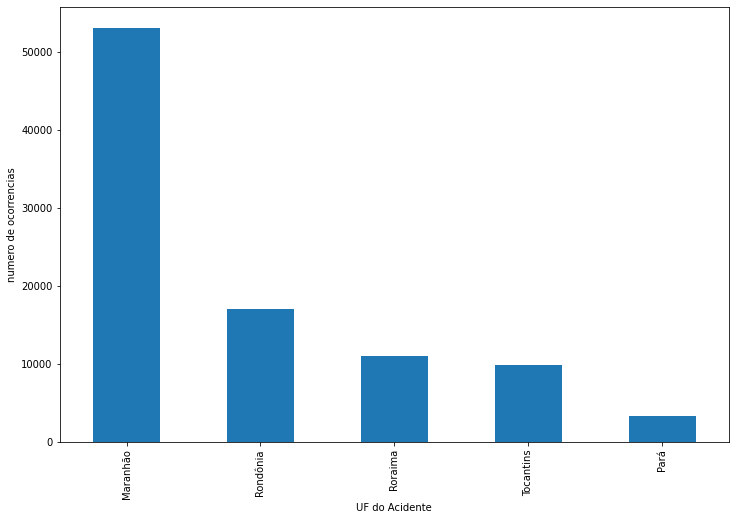

In [ ]:
df2.plot.bar(figsize=(12,8),xlabel='UF do Acidente',ylabel='numero de ocorrencias')

In [ ]:
# INSIGHT 2
# Qual o tipo de acidente que foi mais recorrente registrado no CAT WEB?
df3 = df_pandas_final.groupby(['doenca']).size().sort_values(ascending=False).head(5)

In [ ]:
df3

doenca
Ferim de Dedos s/Lesao da Unha      6257
Frat de Outr Dedos                  6121
Ferim de Dedos c/Lesao da Unha      5207
Entorse e Distensao do Tornozelo    4509
Contusao do Joelho                  2947
dtype: int64

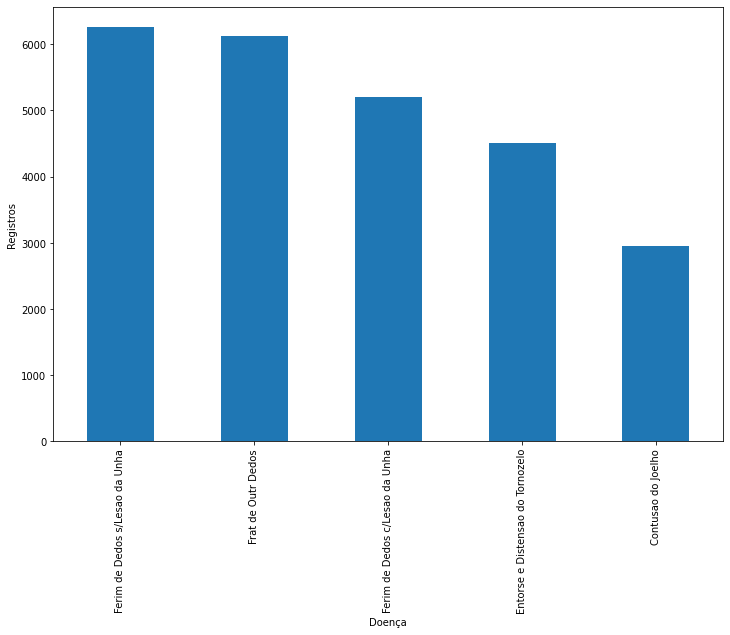

In [ ]:
df3.plot.bar(figsize=(12,8),xlabel='Doença',ylabel='Registros')

In [ ]:
# insight 3
# Qual foi o agente causador com mais registros no mês de janeiro?
ft1 = df_pandas_final['dt_acidente'].dt.month == 1
df1 = df_pandas_final.loc[ft1]
df1 = df1.groupby(['causador_acidente']).size().sort_values(ascending=False).head(5)
df1

causador_acidente
Agente Infeccioso ou Parasitario - Inclui Bac    338
Motocicleta, Motoneta                            110
Rua e Estrada - Superficie Utilizada para Sus     94
Impacto de Pes. Contra Objeto em Movimento        87
Agente do Acidente, Nic                           79
dtype: int64

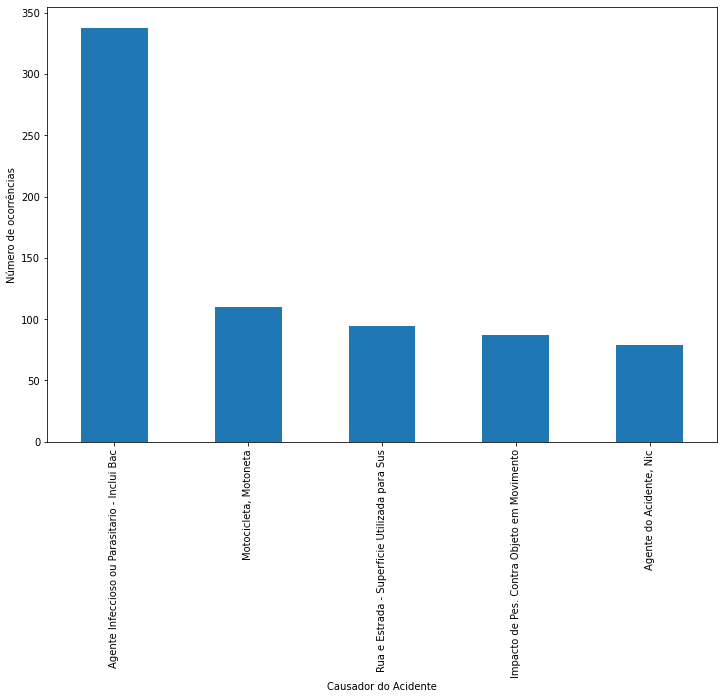

In [ ]:
df1.plot.bar(figsize=(12,8),xlabel='Causador do Acidente',ylabel='Número de ocorrências')

In [ ]:
# insight 4
# Quais lesões mais recorrentes entre os meses de janeiro e fevereiro?
ft2 = df_pandas_final['dt_acidente'].dt.month > 1
ft3 = df_pandas_final['dt_acidente'].dt.month < 2
df4 = df_pandas_final.loc[ft2 & ft3]
df4 = df_pandas_final.groupby(['natureza_lesao']).size().sort_values(ascending=False).head(5)
df4

natureza_lesao
Fratura                                        21578
Corte, Laceracao, Ferida Contusa, Punctura     20372
Lesao Imediata                                 12712
Contusao, Esmagamento (Superficie Cutanea I    11909
Escoriacao, Abrasao (Ferimento Superficial)    10409
dtype: int64

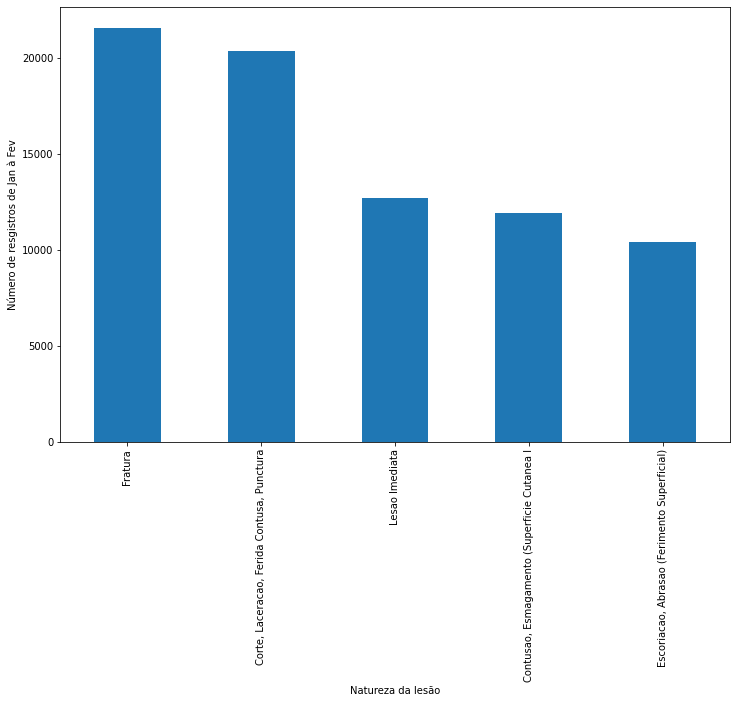

In [ ]:
df4.plot.bar(figsize=(12,8),xlabel='Natureza da lesão',ylabel='Número de resgistros de Jan à Fev')

In [ ]:
# insight 5
# Qual CBO mais registrado entre os meses de abril e maio?
ft4 = df_pandas_final['dt_acidente'].dt.month >= 3
ft5 = df_pandas_final['dt_acidente'].dt.month <= 4
df5 = df_pandas_final.loc[ft4 & ft5].dropna()
df5 = df_pandas_final.groupby(['ocupacao_acidentado']).size().sort_values(ascending=False).head(5)
df5

ocupacao_acidentado
Tec. de Enfermagem                        8182
Alimentador de Linha de Prod.             7516
Motorista de Caminhão (Rotas Regionais    2866
Servente de Obras                         2647
Enfermeiro                                1958
dtype: int64

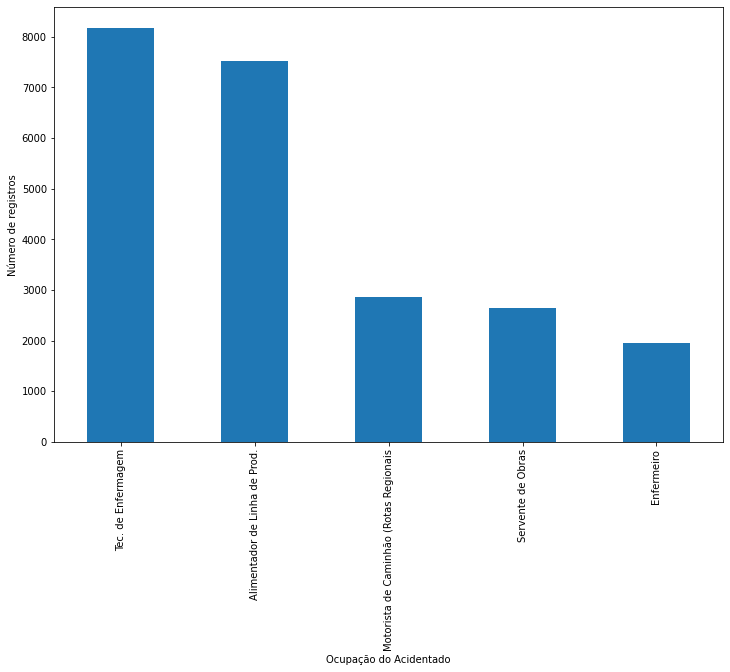

In [ ]:
df5.plot.bar(figsize=(12,8),xlabel='Ocupação do Acidentado',ylabel='Número de registros')

###☑️ **5.2 - Tratamento com Pyspark**

O primeiro item a ser validado com o pyspark será o drop da coluna **Data Acidente.1**, onde o motivo já foi dito anteriormente, mas antes disso precisamos converter o DataFrame para o formato spark.

Podemos fazer isso de duas formas, a primeira seria convertendo o df que usamos no pandas direto para o pyspark e a segunda seria reutornando direto do Data Lake.

####▶️ **Convertendo direto do pandas**

**Montando estrutura com o StructType**



In [ ]:
df.columns

Index(['causador_acidente', 'cbo', 'cod_cid10', 'cod_cnae2.0', 'cnae2.0',
       'emitente', 'beneficio_tipo', 'filiacao_segurado', 'obito', 'munic_emp',
       'natureza_lesao', 'origem_cad', 'parte_corpo', 'sexo', 'tipo_acidente',
       'uf_acidente', 'uf_empregador', 'Data Acidente.1', 'dt_despacho',
       'dt_acidente', 'dt_nasc', 'dt_emissao', 'cnpj'],
      dtype='object')

In [ ]:
# Schema
esquema = (
    StructType([
        StructField('causador_acidente', StringType()),
        StructField('cbo', StringType()),
        StructField('cod_cid10', StringType()),
        StructField('cod_cnae2.0', IntegerType()),
        StructField('cnae2.0', StringType()),
        StructField('emitente', StringType()),
        StructField('beneficio_tipo', StringType()),
        StructField('filiacao_segurado', StringType()),
        StructField('obito', StringType()),
        StructField('munic_emp', StringType()),
        StructField('natureza_lesao', StringType()),
        StructField('origem_cad', StringType()),
        StructField('parte_corpo', StringType()),
        StructField('sexo', StringType()),
        StructField('tipo_acidente', StringType()),
        StructField('uf_acidente', StringType()),
        StructField('uf_empregador', StringType()),
        StructField('Data Acidente.1', StringType()),
        StructField('dt_despacho', StringType()),
        StructField('dt_acidente', DateType()),
        StructField('dt_nasc', DateType()),
        StructField('dt_emissao', DateType()),
        StructField('cnpj', StringType()),
    ])
)

In [ ]:
#Converter do Pandas para o spark
df_spark = spark.createDataFrame(df, schema=esquema)

**Observação:** Caso queira voltar ao pandas, usamos o seguinte comando:

```
 df_pandas = df_spark.toPandas()
```



####▶️ **Puxando arquivo do Data Lake**

Caso queira puxar direto do bucket esse é o caminho:
```
# Localizando arquivo no bucket
path = 'gs://NOME-DO-BUCKET/PASTA-DESTINO/NOME-DO-ARQUIVO.csv'

#Lendo o arquivo CSV que está vindo do bucket
df_spark = ( spark.read.format('csv')
                 .option('header', 'true')
                 .option('inferschema', 'true')
                 .option('delimiter', ';')
                 .load(path)
)
```



In [ ]:
# Visualizando o Schema
df_spark.printSchema()

root
 |-- causador_acidente: string (nullable = true)
 |-- cbo: string (nullable = true)
 |-- cod_cid10: string (nullable = true)
 |-- cod_cnae2.0: integer (nullable = true)
 |-- cnae2.0: string (nullable = true)
 |-- emitente: string (nullable = true)
 |-- beneficio_tipo: string (nullable = true)
 |-- filiacao_segurado: string (nullable = true)
 |-- obito: string (nullable = true)
 |-- munic_emp: string (nullable = true)
 |-- natureza_lesao: string (nullable = true)
 |-- origem_cad: string (nullable = true)
 |-- parte_corpo: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- tipo_acidente: string (nullable = true)
 |-- uf_acidente: string (nullable = true)
 |-- uf_empregador: string (nullable = true)
 |-- Data Acidente.1: string (nullable = true)
 |-- dt_despacho: string (nullable = true)
 |-- dt_acidente: date (nullable = true)
 |-- dt_nasc: date (nullable = true)
 |-- dt_emissao: date (nullable = true)
 |-- cnpj: string (nullable = true)



In [ ]:
# Verificando tamanho do df
df_spark.count()

257401

In [ ]:
# Visualizando o DF spark
df_spark.show(truncate = False)

+---------------------------------------------+---------------------------------------------+---------------------------------------------+-----------+---------------------------------------------+-------------------+--------------+------------------+-----+----------------------------+-------------------------------------------+----------+---------------------------------------------+---------+-------------+----------------+-----------------+---------------+-----------+-----------+----------+----------+------------------+
|causador_acidente                            |cbo                                          |cod_cid10                                    |cod_cnae2.0|cnae2.0                                      |emitente           |beneficio_tipo|filiacao_segurado |obito|munic_emp                   |natureza_lesao                             |origem_cad|parte_corpo                                  |sexo     |tipo_acidente|uf_acidente     |uf_empregador    |Data Acidente.1|dt_despach

Agora que já temos o df no formato pyspark, vamos realizar os tratamentos necessários.



####▶️ **Conversão de datas para formato TimeStamp**

Como o MongoDB não aceita o formato DateTime, precisamos converter as colunas para o formato aceito por ele, para que posteiormente não nos acarrete nenhum erro.

In [ ]:
# Convertendo datas
df_spark = df_spark.withColumn("dt_nasc", to_timestamp(col("dt_nasc"),"dd/MM/yyyy")) \
                 .withColumn("dt_acidente", to_timestamp(col("dt_acidente"),"dd/MM/yyyy")) \
                 .withColumn("dt_emissao", to_timestamp(col("dt_emissao"),"dd/MM/yyyy"))

In [ ]:
# Verificando resultando
df_spark.show(3)

+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+--------------+-----------------+-----+--------------------+--------------------+----------+--------------------+---------+-------------+-----------+-------------+---------------+-----------+-------------------+-------------------+-------------------+------------------+
|   causador_acidente|                 cbo|           cod_cid10|cod_cnae2.0|             cnae2.0|           emitente|beneficio_tipo|filiacao_segurado|obito|           munic_emp|      natureza_lesao|origem_cad|         parte_corpo|     sexo|tipo_acidente|uf_acidente|uf_empregador|Data Acidente.1|dt_despacho|        dt_acidente|            dt_nasc|         dt_emissao|              cnpj|
+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+--------------+-----------------+-----+--------------------+--------------------+----------+---------------

####▶️ **Drop das colunas Data Acidente.1 e origem_cad**

Antes de realizar esse passo, aqui vai uma observação relevante, caso necessário realizar a troca do nome de alguma coluna, esse é o caminho:

```
df_spark = df_spark.withColumnRenamed('COLUNA-ORIGINAL', 'coluna-renomeada')
```

A coluna Data Acidente.1 já foi explicado o motivo de exclusão, já a coluna origem_cad está sendo retirada pois só há dois tipos de informação, ou a informação foi cadastrada pela internet ou está nulo, dessa forma optamos por retirá-la também.


In [ ]:
# Visualizar colunas
df_spark.columns

['causador_acidente',
 'cbo',
 'cod_cid10',
 'cod_cnae2.0',
 'cnae2.0',
 'emitente',
 'beneficio_tipo',
 'filiacao_segurado',
 'obito',
 'munic_emp',
 'natureza_lesao',
 'origem_cad',
 'parte_corpo',
 'sexo',
 'tipo_acidente',
 'uf_acidente',
 'uf_empregador',
 'Data Acidente.1',
 'dt_despacho',
 'dt_acidente',
 'dt_nasc',
 'dt_emissao',
 'cnpj']

In [ ]:
# Remover coluna
df_spark.drop('Data Acidente.1').show()

+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+--------------+------------------+-----+--------------------+--------------------+----------+--------------------+---------+-------------+----------------+-----------------+-----------+-------------------+-------------------+-------------------+------------------+
|   causador_acidente|                 cbo|           cod_cid10|cod_cnae2.0|             cnae2.0|           emitente|beneficio_tipo| filiacao_segurado|obito|           munic_emp|      natureza_lesao|origem_cad|         parte_corpo|     sexo|tipo_acidente|     uf_acidente|    uf_empregador|dt_despacho|        dt_acidente|            dt_nasc|         dt_emissao|              cnpj|
+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+--------------+------------------+-----+--------------------+--------------------+----------+--------------------+-----

In [ ]:
# Verificando se foi alterada
df_spark.columns

['causador_acidente',
 'cbo',
 'cod_cid10',
 'cod_cnae2.0',
 'cnae2.0',
 'emitente',
 'beneficio_tipo',
 'filiacao_segurado',
 'obito',
 'munic_emp',
 'natureza_lesao',
 'origem_cad',
 'parte_corpo',
 'sexo',
 'tipo_acidente',
 'uf_acidente',
 'uf_empregador',
 'Data Acidente.1',
 'dt_despacho',
 'dt_acidente',
 'dt_nasc',
 'dt_emissao',
 'cnpj']

A alteração ainda não foi realizada, pois não houve atribuição, o que você vê é apenas uma pré visualização de como ficará o seu DF caso seja aplicado a alteração.

In [ ]:
# Remover coluna com atribuição Data Acidente.1
df_spark = df_spark.drop('Data Acidente.1')

# Remover coluna com atribuição origem_cad
df_spark = df_spark.drop('origem_cad')

# Verificando se foi alterada
df_spark.columns

['causador_acidente',
 'cbo',
 'cod_cid10',
 'cod_cnae2.0',
 'cnae2.0',
 'emitente',
 'beneficio_tipo',
 'filiacao_segurado',
 'obito',
 'munic_emp',
 'natureza_lesao',
 'parte_corpo',
 'sexo',
 'tipo_acidente',
 'uf_acidente',
 'uf_empregador',
 'dt_despacho',
 'dt_acidente',
 'dt_nasc',
 'dt_emissao',
 'cnpj']

Note que agora já não há mais a coluna **Data Acidente.1** e nem **origem_cad**.

####▶️ **Verificando existência de linhas duplicadas**

Uma das diretrizes do projeto era verificar a existência de linhas duplicadas, faremos isso agora.

In [ ]:
# Verificando tamanho do DataFrame
df_spark.count()

257401

In [ ]:
# Contando as linhas duplicadas
print(f' {df.duplicated().sum()}  Linhas Duplicadas ')

 100652  Linhas Duplicadas 


In [ ]:
# Realizando drop de linhas duplicadas
df_spark = df_spark.dropDuplicates()

In [ ]:
# Verificando tamanho do DataFrame pós alteração
df_spark.count()

156749

Como verificado, não só há linhas duplicadas, como a quantidade delas é bem considerável, algo em torno de 39% do total.

####▶️ **Verificando inconsistências**

Da mesma forma que no pandas, com o pyspark nós filtramos cada coluna para fazer a verificação de possíveis dados inconsistentes.

In [ ]:
df_spark.columns

['causador_acidente',
 'cbo',
 'cod_cid10',
 'cod_cnae2.0',
 'cnae2.0',
 'emitente',
 'beneficio_tipo',
 'filiacao_segurado',
 'obito',
 'munic_emp',
 'natureza_lesao',
 'parte_corpo',
 'sexo',
 'tipo_acidente',
 'uf_acidente',
 'uf_empregador',
 'dt_despacho',
 'dt_acidente',
 'dt_nasc',
 'dt_emissao',
 'cnpj']

In [ ]:
# Verificando colunas
df_spark.groupBy('causador_acidente').count().orderBy(F.col('count').desc()).show(truncate = False)

+---------------------------------------------+-----+
|causador_acidente                            |count|
+---------------------------------------------+-----+
|Não Classificado                             |46288|
|Motocicleta, Motoneta                        |5769 |
|Impacto de Pes. Contra Objeto em Movimento   |5682 |
|Impacto de Pes. Contra Objeto Parado         |4373 |
|Rua e Estrada - Superficie Utilizada para Sus|4333 |
|Chao - Superficie Utilizada para Sustentar Pe|3849 |
|Impacto Sofrido por Pes. de Objeto Que Cai   |3559 |
|Metal - Inclui Liga Ferrosa e nao Ferrosa, Tu|3486 |
|Veiculo, Nic                                 |3462 |
|Veiculo Rodoviario Motorizado                |3420 |
|Queda de Pes. com Dif. de Nivel de Vei       |3362 |
|Faca, Facao- Ferramenta Manual sem Forca Motr|2788 |
|Agente Infeccioso ou Parasitario - Inclui Bac|2557 |
|Queda de Pes. em Mesmo Nivel, Nic            |2238 |
|Impacto Sofrido por Pes., Nic                |2162 |
|Escada Permanente Cujos Deg

Resultado que encontramos:
- **dt_despacho** com cerca de 75% dos dados *0000/00* que vamos deixar como nulo, não vamos dropar a coluna, pois a mesma representa um dado relevante, nem todas as pessoas que se acidentam se afastam por tempo suficiente para receber o benefício;
- **cnpj** com dados *00.000.000.000.000* além de muitos outros com numeros faltantes mas decidimos por retirar a principio apenas os zerados;
- **tipo_acidente** identificamos um valor como *'Ignorado'* que faremos a conversão para Null também, junto com os dados Não Classificados, pois se trata de dado não respondido pelo usuário;
- **munic_emp** identificamos o dado *000000-Ignorado*, que se trata de valor inconsistente, a coluna será renomeada para **local_acidente**, que é o municipio do empregador e local onde aconteceu o acidente, e trataremos o dado como nulo;
- **beneficio_tipo** encontramos um dado com no Pa, mas por não já que não encontramos nenhuma informação adicional, resolvemos passar a frente;
- **cbo** da mesma forma que munic_emp, possui o dado *000000-Ignorado* e será tratado igual, além de ser alterado para **ocupacao_acidentado**;
- As colunas **cod_cnae2.0** e **cnae2.0** não conseguem ser lidas no pyspark e também serão renomeadas para **cod_ativ_economica** e **atv_economica** respectivamente e na coluna cod_ativ_economica os valores *0* presentes representam nulos e também serão considerados como tal.
- A coluna **cod_cid10** também será renomeada para algo mais intuitivo, trocaremos para **doenca**.


####▶️ **Renomeando colunas**

In [ ]:
# Renomeando Colunas
df_spark = (df_spark.withColumnRenamed('munic_emp', 'local_acidente')
                   .withColumnRenamed('cbo', 'ocupacao_acidentado')
                   .withColumnRenamed('cod_cnae2.0', 'cod_ativ_economica')
                   .withColumnRenamed('cnae2.0', 'atv_economica')
                   .withColumnRenamed('cod_cid10', 'doenca'))

In [ ]:
df_spark.show()

+--------------------+--------------------+--------------------+------------------+--------------------+----------+--------------+-----------------+-----+--------------------+--------------------+--------------------+---------+-------------+----------------+-----------------+-----------+-------------------+-------------------+-------------------+------------------+
|   causador_acidente| ocupacao_acidentado|              doenca|cod_ativ_economica|       atv_economica|  emitente|beneficio_tipo|filiacao_segurado|obito|      local_acidente|      natureza_lesao|         parte_corpo|     sexo|tipo_acidente|     uf_acidente|    uf_empregador|dt_despacho|        dt_acidente|            dt_nasc|         dt_emissao|              cnpj|
+--------------------+--------------------+--------------------+------------------+--------------------+----------+--------------+-----------------+-----+--------------------+--------------------+--------------------+---------+-------------+----------------+------

####▶️ **Tratando nulos**

Escolhemos realizar o tratamento para nulo pois além de diminuir o tamanho do arquivo final, os valores nulos acabam não influenciando nos resultados dos insights

In [ ]:
# Tratando coluna dt_despacho
df_spark = df_spark.withColumn('dt_despacho', \
          F.when(F.col('dt_despacho')=="0000/00" ,None) \
          .otherwise(F.col('dt_despacho')))

# Tratando coluna cnpj
df_spark = df_spark.withColumn('cnpj', \
          F.when(F.col('cnpj')=="00.000.000.000.000" ,None) \
          .otherwise(F.col('cnpj')))

# Tratando coluna cod_ativ_economica
df_spark = df_spark.withColumn('cod_ativ_economica', \
          F.when(F.col('cod_ativ_economica')==0 ,None) \
          .otherwise(F.col('cod_ativ_economica')))

In [ ]:
df_spark.show(5)

+--------------------+--------------------+--------------------+------------------+--------------------+----------+--------------+-----------------+-----+----------------+--------------------+--------------------+---------+-------------+----------------+--------------+-----------+-------------------+-------------------+-------------------+----+
|   causador_acidente| ocupacao_acidentado|              doenca|cod_ativ_economica|       atv_economica|  emitente|beneficio_tipo|filiacao_segurado|obito|  local_acidente|      natureza_lesao|         parte_corpo|     sexo|tipo_acidente|     uf_acidente| uf_empregador|dt_despacho|        dt_acidente|            dt_nasc|         dt_emissao|cnpj|
+--------------------+--------------------+--------------------+------------------+--------------------+----------+--------------+-----------------+-----+----------------+--------------------+--------------------+---------+-------------+----------------+--------------+-----------+-------------------+-----

In [ ]:
# Tratando todo DataFrame

# Retirando 000000-Ignorado
df_spark =  df_spark.select([F.when(F.col(x)=="000000-Ignorado",None) \
                 .otherwise(F.col(x)) \
                 .alias(x) for x in df_spark.columns])

# Retirando Ignorado
df_spark = df_spark.select([F.when(F.col(x)=="Ignorado",None) \
                 .otherwise(F.col(x)) \
                 .alias(x) for x in df_spark.columns])

# Retirando Não Classificado
df_spark = df_spark.select([F.when(F.col(x)=="Não Classificado",None) \
                 .otherwise(F.col(x)) \
                 .alias(x) for x in df_spark.columns])

In [ ]:
# Retirando 00/00/0000
df_spark =  df_spark.select([F.when(F.col(x)=="00/00/0000",None) \
                 .otherwise(F.col(x)) \
                 .alias(x) for x in df_spark.columns])

In [ ]:
# Retirando Não Informado
df_spark =  df_spark.select([F.when(F.col(x)=="Não Informado",None) \
                 .otherwise(F.col(x)) \
                 .alias(x) for x in df_spark.columns])

In [ ]:
df_spark.show(200)

+--------------------+--------------------+--------------------+------------------+--------------------+-------------------+--------------+-----------------+-----+--------------------+--------------------+--------------------+---------+-------------+----------------+-------------------+-----------+-------------------+-------------------+-------------------+------------------+
|   causador_acidente| ocupacao_acidentado|              doenca|cod_ativ_economica|       atv_economica|           emitente|beneficio_tipo|filiacao_segurado|obito|      local_acidente|      natureza_lesao|         parte_corpo|     sexo|tipo_acidente|     uf_acidente|      uf_empregador|dt_despacho|        dt_acidente|            dt_nasc|         dt_emissao|              cnpj|
+--------------------+--------------------+--------------------+------------------+--------------------+-------------------+--------------+-----------------+-----+--------------------+--------------------+--------------------+---------+------

####▶️ **Criando novas colunas**

Para esse ponto, vamos utilizar as colunas **ocupacao_acidentado**, **doenca** e **local_acidente**. Os dados pruesentes nessa três colunas possuem o código e a descrição da informação nele, para facilitar a visualização e ajudar nos trabalhos de análise das próximas equipes vamos desmembrá-los em duas colunas cada, uma contendo o cod e a outra o nome propriamente dito.

Além disso, vamos criar uma nova coluna com a idade do acidentado na data da ocorrência, que chamaremos de **idade**.

In [ ]:
# Separar ocupacao_acidentado
df_spark = (df_spark.withColumn('cod_ocupacao_acidentado', F.substring(F.col('ocupacao_acidentado'), 1, 6))
                     .withColumn('ocupacao_acidentado', F.substring(F.col('ocupacao_acidentado'), 8, 10000)))

In [ ]:
# Separar doenca
df_spark = (df_spark.withColumn('cod_doenca', F.substring(F.col('doenca'), 1, 5))
                    .withColumn('doenca', F.substring(F.col('doenca'), 7, 10000)))

In [ ]:
# Separar local_acidente
df_spark = (df_spark.withColumn('cod_local_acidente', F.substring(F.col('local_acidente'), 1, 6))
                    .withColumn('local_acidente', F.substring(F.col('local_acidente'), 8, 10000)))

In [ ]:
# Criando coluna idade
df_spark = df_spark.withColumn('idade', \
          (F.datediff(F.col('dt_acidente'), F.col('dt_nasc'))/365).cast('int'))

In [ ]:
# Verificando alterações
df_spark.show(3)

+--------------------+--------------------+--------------------+------------------+--------------------+----------+--------------+-----------------+-----+--------------+--------------------+--------------------+---------+-------------+-----------+--------------+-----------+-------------------+-------------------+-------------------+----+-----------------------+----------+------------------+-----+
|   causador_acidente| ocupacao_acidentado|              doenca|cod_ativ_economica|       atv_economica|  emitente|beneficio_tipo|filiacao_segurado|obito|local_acidente|      natureza_lesao|         parte_corpo|     sexo|tipo_acidente|uf_acidente| uf_empregador|dt_despacho|        dt_acidente|            dt_nasc|         dt_emissao|cnpj|cod_ocupacao_acidentado|cod_doenca|cod_local_acidente|idade|
+--------------------+--------------------+--------------------+------------------+--------------------+----------+--------------+-----------------+-----+--------------+--------------------+----------

####▶️ **Organizando Data Frame**

Agora que já tratamos todo o DataFrame, vamos organizá-lo de forma a ordenar as informações para facilitar o seu entendimento.

In [ ]:
df_spark.show(5,truncate = False)

+---------------------------------------------+--------------------------------------+--------------------------------------+------------------+---------------------------------------------+----------+--------------+-----------------+-----+--------------+-------------------------------------------+--------------------------------------+---------+-------------+-----------+--------------+-----------+-------------------+-------------------+-------------------+----+-----------------------+----------+------------------+-----+
|causador_acidente                            |ocupacao_acidentado                   |doenca                                |cod_ativ_economica|atv_economica                                |emitente  |beneficio_tipo|filiacao_segurado|obito|local_acidente|natureza_lesao                             |parte_corpo                           |sexo     |tipo_acidente|uf_acidente|uf_empregador |dt_despacho|dt_acidente        |dt_nasc            |dt_emissao         |cnpj|cod_ocu

In [ ]:
# verificando a quantidade de colunas para conferir depois
len(df_spark.columns)

25

In [ ]:
# Organizando DataFrame
df_spark = (df_spark.select(F.col('emitente'), F.col('dt_emissao'), F.col('dt_acidente'), F.col('cod_local_acidente'),
                 F.col('local_acidente'), F.col('uf_acidente'), F.col('cod_doenca'), F.col('doenca'),
                 F.col('natureza_lesao'), F.col('parte_corpo'), F.col('causador_acidente'), F.col('tipo_acidente'),
                 F.col('dt_nasc'), F.col('idade'), F.col('sexo'), F.col('cod_ocupacao_acidentado'),
                 F.col('ocupacao_acidentado'), F.col('cod_ativ_economica'), F.col('atv_economica'), F.col('obito'), 
                 F.col('filiacao_segurado'), F.col('beneficio_tipo'), F.col('dt_despacho'), F.col('uf_empregador'), 
                 F.col('cnpj')
                 ).orderBy(F.col('dt_acidente').desc()))

In [ ]:
# Contando as colunas DataFrame finalizado
len(df_spark.columns)

25

In [ ]:
# Contado as linhas DataFrame finalizado
df_spark.count()

156749

In [ ]:
# Visualizando DataFrame finalizado
df_spark_final = df_spark
df_spark_final.show(5)

+----------+-------------------+-------------------+------------------+--------------+-----------+----------+--------------------+--------------------+--------------------+--------------------+-------------+-------------------+-----+---------+-----------------------+--------------------+------------------+--------------------+-----+-----------------+--------------+-----------+-------------------+----+
|  emitente|         dt_emissao|        dt_acidente|cod_local_acidente|local_acidente|uf_acidente|cod_doenca|              doenca|      natureza_lesao|         parte_corpo|   causador_acidente|tipo_acidente|            dt_nasc|idade|     sexo|cod_ocupacao_acidentado| ocupacao_acidentado|cod_ativ_economica|       atv_economica|obito|filiacao_segurado|beneficio_tipo|dt_despacho|      uf_empregador|cnpj|
+----------+-------------------+-------------------+------------------+--------------+-----------+----------+--------------------+--------------------+--------------------+------------------

In [ ]:
df_spark_final.printSchema()

root
 |-- emitente: string (nullable = true)
 |-- dt_emissao: timestamp (nullable = true)
 |-- dt_acidente: timestamp (nullable = true)
 |-- cod_local_acidente: string (nullable = true)
 |-- local_acidente: string (nullable = true)
 |-- uf_acidente: string (nullable = true)
 |-- cod_doenca: string (nullable = true)
 |-- doenca: string (nullable = true)
 |-- natureza_lesao: string (nullable = true)
 |-- parte_corpo: string (nullable = true)
 |-- causador_acidente: string (nullable = true)
 |-- tipo_acidente: string (nullable = true)
 |-- dt_nasc: timestamp (nullable = true)
 |-- idade: integer (nullable = true)
 |-- sexo: string (nullable = true)
 |-- cod_ocupacao_acidentado: string (nullable = true)
 |-- ocupacao_acidentado: string (nullable = true)
 |-- cod_ativ_economica: integer (nullable = true)
 |-- atv_economica: string (nullable = true)
 |-- obito: string (nullable = true)
 |-- filiacao_segurado: string (nullable = true)
 |-- beneficio_tipo: string (nullable = true)
 |-- dt_desp

####▶️ **Realizando insights com pyspark**

Vamos realizar agora alguns insights com o pyspark, para verificar se nosso dataframe encontra-se usual.

In [ ]:
# window fuctions

#CRIAR UMA PARTIÇÃO SOBRE O DATAFRAME PARA UTILIZAR ALGUM TIPO DE CLASSIFICAÇÃO
w0 = Window.partitionBy(F.col('dt_acidente').isNotNull()).orderBy(F.col('local_acidente').desc())

#CRIAR UMA PARTIÇÃO SOBRE O DATAFRAME PARA UTILIZAR ALGUM TIPO DE CLASSIFICAÇÃO
w1 = Window.partitionBy(F.col('doenca')).orderBy(F.col('dt_acidente').desc())

In [ ]:
(df_spark_final.select(F.col('dt_acidente'), F.col('local_acidente'), F.col('doenca'))
          .withColumn('numero_linha', F.row_number().over(w0))).show(truncate = False)

+-------------------+------------------+---------------------------------------+------------+
|dt_acidente        |local_acidente    |doenca                                 |numero_linha|
+-------------------+------------------+---------------------------------------+------------+
|2022-06-22 00:00:00|Óleo              |Entorse e Distensao do Tornozelo       |1           |
|2022-10-18 00:00:00|Óbidos            |null                                   |2           |
|2022-10-11 00:00:00|Óbidos            |Frat do Esterno                        |3           |
|2022-10-10 00:00:00|Óbidos            |Entorse e Distensao do Tornozelo       |4           |
|2022-06-22 00:00:00|Óbidos            |Contusao de Outr Partes e Partes Ne Do |5           |
|2022-06-16 00:00:00|Óbidos            |Frat de Outr Ossos do Metacarpo        |6           |
|2022-06-01 00:00:00|Óbidos            |Queim de 2.Grau da Cabeca e do Pescoco |7           |
|2022-03-16 00:00:00|Óbidos            |Dor em Membro       

In [ ]:
# Insight 1
# 1. Mostrar a media de idade por sexo das ocorrencias do CATWEB
(df_spark_final.select(F.col('sexo'), F.col('idade'))
               .dropna()
               .groupBy('sexo')
               .agg(F.mean(F.col('idade')).cast('int').alias('media_idade'))
               .show())

+-------------+-----------+
|         sexo|media_idade|
+-------------+-----------+
|Indeterminado|         42|
|     Feminino|         37|
|    Masculino|         36|
+-------------+-----------+



Daí temos a média de idade por sexo, lembrando que realizamos o drop dos valores nulos (nesse caso), pois não faria sentido para a insight.

In [ ]:
#Insight 2
# 2. mostrar as ocorrencias  em que houve obito e que o causador_acidente comece com a palavra motocicleta
df_spark_final.filter(F.col('obito') == 'Sim').filter('causador_acidente like "Motocicleta%"').count()

32

Com isso vemos que houveram 32 ocorrências relatadas em que o causador do acidente começou com motocicleta e a pessoa veio à óbito.

In [ ]:
# Verificando as linhas do Insight 2
df_spark_final.filter(F.col('obito') == 'Sim').filter('causador_acidente like "Motocicleta%"').show()

+----------+-------------------+-------------------+------------------+--------------------+-----------+----------+--------------------+--------------------+--------------------+--------------------+-------------+-------------------+-----+---------+-----------------------+--------------------+------------------+--------------------+-----+-----------------+--------------+-----------+-------------------+------------------+
|  emitente|         dt_emissao|        dt_acidente|cod_local_acidente|      local_acidente|uf_acidente|cod_doenca|              doenca|      natureza_lesao|         parte_corpo|   causador_acidente|tipo_acidente|            dt_nasc|idade|     sexo|cod_ocupacao_acidentado| ocupacao_acidentado|cod_ativ_economica|       atv_economica|obito|filiacao_segurado|beneficio_tipo|dt_despacho|      uf_empregador|              cnpj|
+----------+-------------------+-------------------+------------------+--------------------+-----------+----------+--------------------+--------------

In [ ]:
# Insight 3
# 3. mostrar todas as ocorrencias de Masculino entre 30 e 50 anos que tenha natureza_lesao que contenha fratura
(df_spark_final.filter(F.col('sexo') == 'Masculino')
               .filter(F.col('idade') >=30)
               .filter(F.col('idade') <= 50)
               .filter(F.col('natureza_lesao').contains('Fratura'))).count()

8507

Vemos que 8.507 homens entre 30 e 50 anos registraram uma ocorrência em que a natureza da lesão fora Fratura.

In [ ]:
(df_spark_final.filter(F.col('sexo') == 'Masculino')
               .filter(F.col('idade') >=30)
               .filter(F.col('idade') <= 50)
               .filter(F.col('natureza_lesao').contains('Fratura'))).show()

+----------+-------------------+-------------------+------------------+--------------------+-----------+----------+--------------------+--------------+--------------------+--------------------+-------------+-------------------+-----+---------+-----------------------+--------------------+------------------+--------------------+-----+-----------------+--------------+-----------+-----------------+----+
|  emitente|         dt_emissao|        dt_acidente|cod_local_acidente|      local_acidente|uf_acidente|cod_doenca|              doenca|natureza_lesao|         parte_corpo|   causador_acidente|tipo_acidente|            dt_nasc|idade|     sexo|cod_ocupacao_acidentado| ocupacao_acidentado|cod_ativ_economica|       atv_economica|obito|filiacao_segurado|beneficio_tipo|dt_despacho|    uf_empregador|cnpj|
+----------+-------------------+-------------------+------------------+--------------------+-----------+----------+--------------------+--------------+--------------------+--------------------+-

In [ ]:
# Insight 4
# 4. Mostrar acidentes do segundo semestre de 2022 das mulheres em que uf_acidente seja Maranhão
(df_spark_final.filter(F.col('sexo') == 'Feminino')
               .filter(F.col('uf_acidente').like('Maranhão'))
               .filter(F.col('dt_acidente')>= '2022-06-01 00:00:00')).count()

7302

Ocorreram no segundo semestre de 2022, 7.302 ocorrências de mulheres onde a uf do acidente foi Maranhão.

In [ ]:
(df_spark_final.filter(F.col('sexo') == 'Feminino')
               .filter(F.col('uf_acidente').like('Maranhão'))
               .filter(F.col('dt_acidente')>= '2022-06-01 00:00:00')).show()

+------------------+-------------------+-------------------+------------------+--------------+-----------+----------+--------------------+--------------------+--------------------+--------------------+-------------+-------------------+-----+--------+-----------------------+--------------------+------------------+--------------------+-----+-----------------+--------------+-----------+-------------+------------------+
|          emitente|         dt_emissao|        dt_acidente|cod_local_acidente|local_acidente|uf_acidente|cod_doenca|              doenca|      natureza_lesao|         parte_corpo|   causador_acidente|tipo_acidente|            dt_nasc|idade|    sexo|cod_ocupacao_acidentado| ocupacao_acidentado|cod_ativ_economica|       atv_economica|obito|filiacao_segurado|beneficio_tipo|dt_despacho|uf_empregador|              cnpj|
+------------------+-------------------+-------------------+------------------+--------------+-----------+----------+--------------------+--------------------+-

In [ ]:
# Insight 5
# 5. Mostrar quais são as cinco doenças com maior numeros de ocorrencias

# DSelecionando apenas coluna 'doenca'
dfteste = df_spark_final.select(F.col('doenca'))

# Eliminando nulos
dfteste = dfteste.dropna()

#visualizando reusultado da insight
dfteste.groupBy(F.col('doenca')).count().orderBy(F.col('count').desc()).show(5, truncate = False)

+--------------------------------+-----+
|doenca                          |count|
+--------------------------------+-----+
|Ferim de Dedos s/Lesao da Unha  |6257 |
|Frat de Outr Dedos              |6121 |
|Ferim de Dedos c/Lesao da Unha  |5207 |
|Entorse e Distensao do Tornozelo|4509 |
|Contusao do Joelho              |2947 |
+--------------------------------+-----+
only showing top 5 rows



In [ ]:
# Gerando arquivo pandas
df_pandas_final = df_spark_final.toPandas()

Vimos que as campeãs de ocorrências são as listadas acima.

## 💿 **6 - Carregando DataFrame tratado nos Data Lakes**

Finalizado o processo de tratamento do Dataframe, faremos a parte final do nosso trabalho, que é a de Carga dos arquivos, novamente para nossos Data Lakes e dessa vez, também disponibilizaremos os dados em um banco de dados MySQL no Google Cloud SQL.

### ☑️**6.1 - Carregando para o MongoDB**

Como já fizemos a conexão com o Mongo Atlas, não se faz necessário abrir uma nova seção, então vamos enviar o arquivo tratado para seu destino.

In [ ]:
# Enderenço do cluster                   
uri = "mongodb+srv://cluster0.2qynihy.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"

# Altenticando o Mongo
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='/content/chave-mongo-projetodupla.pem')

#Escolha do DataBase e Coleção
db_projeto = client['projeto_aquecimento']

# Criando a coleção para o df_cat final
colecaocat1 = db_projeto['DF-CAT-2022-trat']

In [ ]:
df_pandas_final.head(3)

,emitente,dt_emissao,dt_acidente,cod_local_acidente,local_acidente,uf_acidente,cod_doenca,doenca,natureza_lesao,parte_corpo,causador_acidente,tipo_acidente,dt_nasc,idade,sexo,cod_ocupacao_acidentado,ocupacao_acidentado,cod_ativ_economica,atv_economica,obito,filiacao_segurado,beneficio_tipo,dt_despacho,uf_empregador,cnpj
0,Empregador,2022-10-31 00:00:00,2022-10-31,240420,Goianinha,None,S60.1,Contusao de Dedos c/Lesao da Unha,"Corte, Laceracao, Ferida Contusa, Punctura",Dedo,Impacto de Pes. Contra Objeto Parado,Típico,1994-01-09 00:00:00,29.0,Masculino,862150,"Oper. Máquinas Fixas, em Geral",2342.0,Fabricacao de Produtos Ceramicos Nao-Refratar,Não,Empregado,Pa,None,Rio Grande do Norte,None
1,Empregador,2022-10-31 00:00:00,2022-10-31,352400,Itupeva,Maranhão,W00.5,Areas de Comercio e de Servicos,"Outras Lesoes, Nic",Partes Multiplas - Aplica-Se Quando Mais de U,Agente do Acidente Inexistente,Típico,1979-12-10 00:00:00,43.0,Masculino,411010,Assistente Administrativo,2071.0,"Fabricacao de Tintas, Vernizes, Esmaltes e La",Não,Empregado,Pa,None,São Paulo,None
2,Empregador,2022-10-31 00:00:00,2022-10-31,330240,Macaé,Tocantins,S61.0,Ferim de Dedos s/Lesao da Unha,"Corte, Laceracao, Ferida Contusa, Punctura",Dedo,"Embalagem e Recipiente, Vazio ou Cheio, Nic",Típico,2000-10-18 00:00:00,22.0,Masculino,513315,Camareiro Hotel,4729.0,Comercio Varejista de Produtos Alimenticios e,Não,Empregado,Pa,None,Rio de Janeiro,None


⚠️**Observação:** O **MongoDB** não aceita inserção de valores **NaT**, além de aceitar apenas o formato de data **TimeStamp**, somente para esse modelo de Data Lake vamos substituir os valores **Nulos** das colunas *'dt_emissao'* e *'dt_nasc'* por **0**, para que consigamos subir os dados ao destino final.'

In [ ]:
df_pandas_final['dt_emissao'].fillna(None, inplace = True)
df_pandas_final['dt_nasc'].fillna(None, inplace = True)

In [ ]:
df_dict = df_pandas_final.to_dict('records')

In [ ]:
#Enviar o df_spark para colecao selecionada no mongo
colecaocat1.insert_many(df_dict)

In [ ]:
# Verificando a quantidade de documentos da coleção cat1
colecaocat1.count_documents({})

156749

###☑️ **6.2 - Carregando para o Cloud Storage**

Da mesma forma, a conexão com o Bucket também já fora realizada e agora é só enviar o arquivo para o seu destino final.

In [ ]:
# Gerando arquivo do formato csv
df_spark_final.write.format('csv').save('DF-CAT-2022-tratado.csv')

In [ ]:
# Escolhendo arquivo dentro da bucket
blob = bucket.blob('datasets-tratados/DF-CAT-2022-tratado.csv')

# Enviando arquivos
blob.upload_from_filename('/content/DF-CAT-2022-tratado.csv')

Enviado para o bucket do projeto GCP: projeto-ab-bc26, na pasta: datasets-tratados.

Outra maneira de enviar, sem a necessidade de criar um arquivo temporário está descrita logo abaixo:

```
df_pandas_final = sparkDF.toPandas() 
bucket.blob('datasets-tratados/DF-CAT-2022-tratado.csv') \
      .upload_from_string(df_pandas_final.to_csv(sep=';', encoding='ISO-8859-1',index=False), 'DF-CAT-2022-tratado.csv')
```



###☑️ **6.3 - Disponibilizando dados no CloudSQL (MySQL)**

A maneira mais simples e rápida de fazer esse processo é convertendo um DataFrame pandas para o formato sql e enviando o mesmo para o banco MySQL do CloudSQL, vamos mostrar como fazer esse passo.

In [ ]:
# Indicando parametros de conexão
INSTANCE_CONNECTION_NAME = f"projeto-dupla-bc26:us-central1:projeto-aquecimento" # i.e demo-project:us-central1:demo-instance
print(f"Your instance connection name is: {INSTANCE_CONNECTION_NAME}")
DB_USER = "root"
DB_PASS = "root"
DB_NAME = "aquecimento"

Your instance connection name is: projeto-dupla-bc26:us-central1:projeto-aquecimento


In [ ]:
# iniciando variável de conexão
connector = Connector()

# Gerando função de retorno da conexão
def getconn():
    conn = connector.connect(
        INSTANCE_CONNECTION_NAME,
        "pymysql",
        user=DB_USER,
        password=DB_PASS,
        db=DB_NAME
    )
    return conn

# Criando a conexão
pool = sqlalchemy.create_engine(
    "mysql+pymysql://",
    creator=getconn,
)

In [ ]:
# Convertendo DataFrame final Spark para pandas
df_pandas_final = df_spark_final.toPandas()

In [ ]:
# Enviando para o MYSQL
df_pandas_final.to_sql('catweb2022_trat', con=pool)

In [ ]:
# Utilizando sparkSQL para realizar queries 

# Retorna o primeiro
pool.connect() \
    .execute("SELECT dt_acidente FROM catweb2022_trat WHERE doenca = 'Entorse e Distensao do Tornozelo'") \
    .fetchone()

(datetime.date(2022, 3, 1),)

In [ ]:
# Retorna o todos
pool.connect() \
    .execute("SELECT dt_acidente FROM catweb2022_trat WHERE doenca = 'Entorse e Distensao do Tornozelo'") \
    .fetchall()

[(datetime.date(2022, 3, 1),),
 (datetime.date(2022, 3, 4),),
 (datetime.date(2022, 3, 11),),
 (datetime.date(2022, 3, 14),),
 (datetime.date(2022, 3, 21),),
 (datetime.date(2022, 3, 10),),
 (datetime.date(2022, 3, 29),),
 (datetime.date(2022, 3, 30),),
 (datetime.date(2022, 6, 1),),
 (datetime.date(2022, 5, 23),),
 (datetime.date(2022, 6, 3),),
 (datetime.date(2022, 6, 3),),
 (datetime.date(2022, 5, 25),),
 (datetime.date(2022, 6, 6),),
 (datetime.date(2022, 6, 7),),
 (datetime.date(2022, 6, 3),),
 (datetime.date(2022, 6, 1),),
 (datetime.date(2022, 6, 13),),
 (datetime.date(2022, 6, 11),),
 (datetime.date(2022, 6, 19),),
 (datetime.date(2022, 6, 3),),
 (datetime.date(2022, 6, 20),),
 (datetime.date(2022, 6, 23),),
 (datetime.date(2022, 6, 24),),
 (datetime.date(2022, 6, 3),),
 (datetime.date(2022, 6, 20),),
 (datetime.date(2022, 10, 6),),
 (datetime.date(2022, 8, 31),),
 (datetime.date(2022, 2, 28),),
 (datetime.date(2022, 3, 4),),
 (datetime.date(2022, 3, 8),),
 (datetime.date(2022,

In [ ]:
# Para limpar a conexão
connector.close()

🚧**Nota:** Para mais informações sobre esse conector, basta acessar a documentação que fala sobre ele clicando [aqui](https://colab.research.google.com/github/GoogleCloudPlatform/cloud-sql-python-connector/blob/main/samples/notebooks/mysql_python_connector.ipynb#scrollTo=GpVKrv0TCXje).👈

# ![theend.gif](https://storage.googleapis.com/projeto-ab-bc26/Images/theend2.gif)
E é isso, concluimos aqui nosso processo de ELTL, onde mostramos a você os principios básicos do trabalho de um engenheiro de dados, tudo que desenvolvemos até aqui é obra do bootcamp da SoulCode e de seus professores,espero que tenham gostado e até a próxima! 😜🖖